# 前処理＋特徴量エンジアリング

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install seaborn==0.12.2
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5
# !pip install optuna==3.1.1
# !pip install plotly==5.13.1

In [ ]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__) 
print(lgb.__version__)

1.5.3
1.22.4
3.7.1
0.12.2
1.2.2
3.3.5


In [ ]:
# データ読み込み、外れ値の除外

# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
# 数値×数値の特徴量エンジニアリング

# 密度（重さ/体積）
X['density'] = X['carat'] / (X['x'] * X['y'] * X['z'])

# 差分
X['x-y'] = (X['x'] - X['y']).abs()
X['y-z'] = (X['y'] - X['z']).abs()
X['z-x'] = (X['x'] - X['y']).abs()

# 比率
X['x/y'] = X['x'] / X['y']
X['y/z'] = X['y'] / X['z']
X['z/x'] = X['z'] / X['x']

# 中央値との差分
X['x-median_x'] = (X['x'] - X['x'].median()).abs()
X['y-median_y'] = (X['y'] - X['y'].median()).abs()
X['z-median_z'] = (X['z'] - X['z'].median()).abs()

print('追加した特徴量')
display(X.head())

追加した特徴量


,carat,cut,color,clarity,depth,table,x,y,z,density,x-y,y-z,z-x,x/y,y/z,z/x,x-median_x,y-median_y,z-median_z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,0.03,1.55,0.03,0.992462,1.637860,0.615190,1.75,1.73,1.10
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,0.05,1.53,0.05,1.013021,1.662338,0.593830,1.81,1.87,1.22
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,0.02,1.76,0.02,0.995086,1.761905,0.570370,1.65,1.64,1.22
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,0.03,1.60,0.03,0.992908,1.608365,0.626190,1.50,1.48,0.90
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,0.01,1.60,0.01,0.997701,1.581818,0.633641,1.36,1.36,0.78


In [ ]:
# カテゴリ変数×数値の特徴量エンジニアリング

# カテゴリ変数cutごとにcarat中央値を集計
X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()
X_carat_by_cut.columns = ['cut', 'median_carat_by_cut']
print('cutごとにcarat中央値を集計')
display(X_carat_by_cut)
X = pd.merge(X, X_carat_by_cut, on='cut', how = 'left')
X['carat-median_carat_by_cut'] = (X['carat'] - X['median_carat_by_cut'])
X['carat/median_carat_by_cut'] = (X['carat'] / X['median_carat_by_cut'])

# カテゴリ変数colorごとにcarat中央値を集計
X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()
X_carat_by_color.columns = ['color', 'median_carat_by_color']
print('colorごとにcarat中央値を集計')
display(X_carat_by_color)
X = pd.merge(X, X_carat_by_color, on='color', how = 'left')
X['carat-median_carat_by_color'] = (X['carat'] - X['median_carat_by_color'])
X['carat/median_carat_by_color'] = (X['carat'] / X['median_carat_by_color'])

# カテゴリ変数clarityごとにcarat中央値を集計
X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()
X_carat_by_clarity.columns = ['clarity', 'median_carat_by_clarity']
print('clarityごとにcarat中央値を集計')
display(X_carat_by_clarity)
X = pd.merge(X, X_carat_by_clarity, on='clarity', how = 'left')
X['carat-median_carat_by_clarity'] = (X['carat'] - X['median_carat_by_clarity'])
X['carat/median_carat_by_clarity'] = (X['carat'] / X ['median_carat_by_clarity'])

display(X.head())

cutごとにcarat中央値を集計


,cut,median_carat_by_cut
0,Ideal,0.54
1,Premium,0.85
2,Very Good,0.71
3,Good,0.82
4,Fair,1.00


colorごとにcarat中央値を集計


,color,median_carat_by_color
0,D,0.53
1,E,0.53
2,F,0.70
3,G,0.70
4,H,0.90
5,I,1.00
6,J,1.11


clarityごとにcarat中央値を集計


,clarity,median_carat_by_clarity
0,IF,0.35
1,VVS1,0.39
2,VVS2,0.44
3,VS1,0.57
4,VS2,0.63
5,SI1,0.76
6,SI2,1.01
7,I1,1.11


,carat,cut,color,clarity,depth,table,x,y,z,density,...,z-median_z,median_carat_by_cut,carat-median_carat_by_cut,carat/median_carat_by_cut,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,...,1.10,0.54,-0.31,0.425926,0.53,-0.30,0.433962,1.01,-0.78,0.227723
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,...,1.22,0.85,-0.64,0.247059,0.53,-0.32,0.396226,0.76,-0.55,0.276316
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,...,1.22,0.82,-0.59,0.280488,0.53,-0.30,0.433962,0.57,-0.34,0.403509
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,...,0.90,0.85,-0.56,0.341176,1.00,-0.71,0.290000,0.63,-0.34,0.460317
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,...,0.78,0.82,-0.51,0.378049,1.11,-0.80,0.279279,1.01,-0.70,0.306931


In [ ]:
# カテゴリ変数×カテゴリ変数の特徴量エンジニアリング

# cut*colorの出現割合
X_tbl = pd.crosstab(X['cut'], X['color'], normalize='index')
X_tbl = X_tbl.reset_index()
print('cut*colorの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='cut', value_name='rate_cut*color')
X = pd.merge(X, X_tbl, on=['cut', 'color'], how='left' )

# color*clarityの出現割合
X_tbl = pd.crosstab(X['color'], X['clarity'], normalize='index')
X_tbl = X_tbl.reset_index()
print('color*clarityの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='color', value_name='rate_color*clarity')
X = pd.merge(X, X_tbl, on=['color', 'clarity'], how='left' )

# clarity*cutの出現割合
X_tbl = pd.crosstab(X['clarity'], X['cut'], normalize='index')
X_tbl = X_tbl.reset_index()
print('clarity*cutの出現割合')
display(X_tbl)
X_tbl = pd.melt(X_tbl, id_vars='clarity', value_name='rate_clarity*cut')
X = pd.merge(X, X_tbl, on=['clarity', 'cut'], how='left' )

display(X.head())

cut*colorの出現割合


color,cut,D,E,F,G,H,I,J
0,Ideal,0.131526,0.181092,0.177519,0.226574,0.144568,0.097136,0.041584
1,Premium,0.116281,0.169631,0.169122,0.212020,0.170864,0.103506,0.058576
2,Very Good,0.125259,0.198609,0.179154,0.190330,0.150923,0.099594,0.056130
3,Good,0.135047,0.190330,0.185027,0.177275,0.143207,0.106487,0.062627
4,Fair,0.101494,0.139477,0.194271,0.194894,0.188045,0.108966,0.072852


color*clarityの出現割合


clarity,color,IF,VVS1,VVS2,VS1,VS2,SI1,SI2,I1
0,D,0.010776,0.037053,0.081636,0.104074,0.250517,0.307499,0.202244,0.006200
1,E,0.016131,0.066973,0.101174,0.130577,0.252169,0.247677,0.174885,0.010413
2,F,0.040365,0.076955,0.102223,0.143007,0.230761,0.223422,0.168274,0.014993
3,G,0.060351,0.088532,0.127880,0.190269,0.207816,0.175115,0.136920,0.013116
4,H,0.036041,0.070516,0.073288,0.140911,0.197806,0.274108,0.188042,0.019286
5,I,0.026389,0.065510,0.067356,0.177524,0.215722,0.262595,0.168297,0.016608
6,J,0.018182,0.026381,0.046702,0.193226,0.260606,0.267380,0.170766,0.016756


clarity*cutの出現割合


cut,clarity,Ideal,Premium,Very Good,Good,Fair
0,I1,0.199454,0.274590,0.113388,0.129781,0.282787
1,IF,0.677095,0.128492,0.149721,0.039665,0.005028
2,SI1,0.327796,0.273521,0.248029,0.119421,0.031233
3,SI2,0.282774,0.320449,0.228659,0.117378,0.050740
4,VS1,0.439275,0.243511,0.217189,0.079334,0.020690
5,VS2,0.413661,0.273870,0.211360,0.079811,0.021299
6,VVS1,0.560208,0.168309,0.215928,0.050903,0.004652
7,VVS2,0.514410,0.171733,0.243782,0.056455,0.013620


,carat,cut,color,clarity,depth,table,x,y,z,density,...,carat/median_carat_by_cut,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity,rate_cut*color,rate_color*clarity,rate_clarity*cut
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,...,0.425926,0.53,-0.30,0.433962,1.01,-0.78,0.227723,0.181092,0.174885,0.282774
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,...,0.247059,0.53,-0.32,0.396226,0.76,-0.55,0.276316,0.169631,0.247677,0.273521
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,...,0.280488,0.53,-0.30,0.433962,0.57,-0.34,0.403509,0.190330,0.130577,0.079334
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,...,0.341176,1.00,-0.71,0.290000,0.63,-0.34,0.460317,0.103506,0.215722,0.273870
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,...,0.378049,1.11,-0.80,0.279279,1.01,-0.70,0.306931,0.062627,0.170766,0.117378


In [ ]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 31)  y_trainの形状： (43128,)  X_testの形状： (10783, 31)  y_testの形状： (10783,)


In [ ]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

In [ ]:
# カテゴリ変数のデータ型をcategoryに変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43128 entries, 2640 to 2732
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   carat                          43128 non-null  float64 
 1   cut                            43128 non-null  category
 2   color                          43128 non-null  category
 3   clarity                        43128 non-null  category
 4   depth                          43128 non-null  float64 
 5   table                          43128 non-null  float64 
 6   x                              43128 non-null  float64 
 7   y                              43128 non-null  float64 
 8   z                              43128 non-null  float64 
 9   density                        43128 non-null  float64 
 10  x-y                            43128 non-null  float64 
 11  y-z                            43128 non-null  float64 
 12  z-x                           

In [ ]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


# ハイパーパラメータ最適化

In [ ]:
# ライブラリoptunaのインストール
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
# optunaのバージョン確認
import optuna
optuna.__version__

'3.1.1'

In [ ]:
# 固定値のハイパーパラメータ
params_base = {
    'objective': 'mae',
    'random_seed': 1234,
    'learning_rate': 0.02,
    'min_data_in_bin': 3,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbose': -1,
}

In [ ]:
# ハイパーパラメータ最適化

# ハイパーパラメータの探索範囲
def objective(trial):
  params_tuning = {
      'num_leaves': trial.suggest_int('num_leaves', 50, 200),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 30),
      'max_bin': trial.suggest_int('max_bin', 200, 400),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 0.95),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.65),
      'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
      'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1, log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1, log=True),
  }
  
  # 探索用ハイパーパラメータの設定
  params_tuning.update(params_base)

  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_va, y_va)
  
  # 探索用ハイパーパラメータで学習
  model = lgb.train(params_tuning,
                    lgb_train,
                    num_boost_round=10000,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train', 'valid'],
                    callbacks=[lgb.early_stopping(100),
                               lgb.log_evaluation(500)])
  
  y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
  score =  mean_absolute_error(y_va, y_va_pred)
  print('')

  return score

In [ ]:
# ハイパーパラメータ最適化の実行
import optuna
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=200)

[I 2023-05-27 13:20:51,939] A new study created in memory with name: no-name-823157ea-303c-44e4-b053-11413147b472


Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.794	valid's l1: 240.975
[1000]	train's l1: 185.235	valid's l1: 237.404
[1500]	train's l1: 169.985	valid's l1: 236.718
Early stopping, best iteration is:
[1747]	train's l1: 165.084	valid's l1: 236.395


[I 2023-05-27 13:21:53,085] Trial 0 finished with value: 236.3953978396676 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'feature_fraction': 0.4770964398016714, 'min_gain_to_split': 0.19578897201213002, 'lambda_l1': 0.07501954443620121, 'lambda_l2': 0.6074996073425692}. Best is trial 0 with value: 236.3953978396676.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.499	valid's l1: 240.151
[1000]	train's l1: 164.338	valid's l1: 237.211
Early stopping, best iteration is:
[1050]	train's l1: 161.972	valid's l1: 237.084


[I 2023-05-27 13:22:17,327] Trial 1 finished with value: 237.08390346573412 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'feature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_l1': 0.013869861245357327, 'lambda_l2': 0.014936835544198456}. Best is trial 0 with value: 236.3953978396676.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 238.391	valid's l1: 245.206
[1000]	train's l1: 220.304	valid's l1: 240.855
[1500]	train's l1: 207.881	valid's l1: 239.386
[2000]	train's l1: 198.399	valid's l1: 238.345
[2500]	train's l1: 192.781	valid's l1: 237.828
[3000]	train's l1: 187.799	valid's l1: 237.462
Early stopping, best iteration is:
[3155]	train's l1: 185.873	valid's l1: 237.412


[I 2023-05-27 13:22:53,545] Trial 2 finished with value: 237.41216752547192 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'feature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.39656750817710085, 'lambda_l1': 0.08374496868436809, 'lambda_l2': 0.3639639356786389}. Best is trial 0 with value: 236.3953978396676.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 233.757	valid's l1: 243.269
[1000]	train's l1: 210.193	valid's l1: 238.663
[1500]	train's l1: 196.532	valid's l1: 237.372
[2000]	train's l1: 186.194	valid's l1: 236.913
Early stopping, best iteration is:
[2034]	train's l1: 185.763	valid's l1: 236.894


[I 2023-05-27 13:23:16,073] Trial 3 finished with value: 236.89405915464317 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'feature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_l1': 0.0338151426782029, 'lambda_l2': 0.35356346291488117}. Best is trial 0 with value: 236.3953978396676.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.974	valid's l1: 240.78
[1000]	train's l1: 189.871	valid's l1: 237.593
[1500]	train's l1: 174.181	valid's l1: 236.556
[2000]	train's l1: 164.279	valid's l1: 235.934
[2500]	train's l1: 155.636	valid's l1: 235.643
Early stopping, best iteration is:
[2610]	train's l1: 154.231	valid's l1: 235.601


[I 2023-05-27 13:23:54,328] Trial 4 finished with value: 235.6009181590289 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'feature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_l1': 0.7717846862118062, 'lambda_l2': 0.23101522250182369}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.468	valid's l1: 241.746
[1000]	train's l1: 192.622	valid's l1: 238.472
[1500]	train's l1: 175.797	valid's l1: 237.062
[2000]	train's l1: 165.327	valid's l1: 236.569
Early stopping, best iteration is:
[1985]	train's l1: 165.615	valid's l1: 236.566


[I 2023-05-27 13:24:26,242] Trial 5 finished with value: 236.56553064240038 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'feature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_l1': 0.02634905974115613, 'lambda_l2': 0.01810725406663109}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.96	valid's l1: 241.61
[1000]	train's l1: 192.155	valid's l1: 238.33
[1500]	train's l1: 178.584	valid's l1: 237.332
[2000]	train's l1: 167.479	valid's l1: 236.773
[2500]	train's l1: 157.094	valid's l1: 236.191
Early stopping, best iteration is:
[2631]	train's l1: 155.13	valid's l1: 236.124


[I 2023-05-27 13:25:06,195] Trial 6 finished with value: 236.123526792667 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'feature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_l1': 0.02616697456085447, 'lambda_l2': 0.021019338091154416}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.939	valid's l1: 240.844
[1000]	train's l1: 178.555	valid's l1: 237.253
[1500]	train's l1: 159.209	valid's l1: 236.406
Early stopping, best iteration is:
[1895]	train's l1: 148.122	valid's l1: 236.148


[I 2023-05-27 13:25:39,392] Trial 7 finished with value: 236.14758156608585 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'feature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_l1': 0.20542778286285945, 'lambda_l2': 0.018895826938026012}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.883	valid's l1: 242.298
[1000]	train's l1: 203.695	valid's l1: 238.466
[1500]	train's l1: 190.018	valid's l1: 237.42
[2000]	train's l1: 180.115	valid's l1: 236.993
Early stopping, best iteration is:
[2379]	train's l1: 173.571	valid's l1: 236.576


[I 2023-05-27 13:26:11,961] Trial 8 finished with value: 236.57602513147754 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'feature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_l1': 0.8972612866432508, 'lambda_l2': 0.08655704137361815}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.772	valid's l1: 240.329
[1000]	train's l1: 169.899	valid's l1: 237.108
[1500]	train's l1: 154.233	valid's l1: 236.402
Early stopping, best iteration is:
[1417]	train's l1: 156.273	valid's l1: 236.394


[I 2023-05-27 13:26:42,879] Trial 9 finished with value: 236.3942096446911 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'feature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_l1': 0.0391093317225106, 'lambda_l2': 0.0172764870082179}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.076	valid's l1: 240.925
[1000]	train's l1: 175.684	valid's l1: 236.825
[1500]	train's l1: 155.785	valid's l1: 236.29
Early stopping, best iteration is:
[1817]	train's l1: 146.881	valid's l1: 235.914


[I 2023-05-27 13:27:08,127] Trial 10 finished with value: 235.91394457126538 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 4, 'max_bin': 204, 'bagging_fraction': 0.9086211983673774, 'feature_fraction': 0.3583168079743905, 'min_gain_to_split': 0.08252107415938004, 'lambda_l1': 0.5598399615905776, 'lambda_l2': 0.12445301121282816}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.392	valid's l1: 241.213
[1000]	train's l1: 174.307	valid's l1: 237.616
[1500]	train's l1: 153.869	valid's l1: 236.609
[2000]	train's l1: 141.929	valid's l1: 236.205
Early stopping, best iteration is:
[2027]	train's l1: 141.268	valid's l1: 236.153


[I 2023-05-27 13:27:37,292] Trial 11 finished with value: 236.1528459013989 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 3, 'max_bin': 200, 'bagging_fraction': 0.9120148167627737, 'feature_fraction': 0.37029317112273297, 'min_gain_to_split': 0.07815734384464, 'lambda_l1': 0.6726718629744891, 'lambda_l2': 0.12802682779428146}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.415	valid's l1: 240.6
[1000]	train's l1: 170.612	valid's l1: 236.735
[1500]	train's l1: 150.764	valid's l1: 235.978
Early stopping, best iteration is:
[1787]	train's l1: 142.829	valid's l1: 235.686


[I 2023-05-27 13:28:05,671] Trial 12 finished with value: 235.68553113118287 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 2, 'max_bin': 251, 'bagging_fraction': 0.9084389567643958, 'feature_fraction': 0.3521798778434926, 'min_gain_to_split': 0.045633217357811416, 'lambda_l1': 0.4346927884140068, 'lambda_l2': 0.1445025316423963}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.412	valid's l1: 240.63
[1000]	train's l1: 178.526	valid's l1: 237.941
Early stopping, best iteration is:
[1380]	train's l1: 165.721	valid's l1: 237.39


[I 2023-05-27 13:28:32,991] Trial 13 finished with value: 237.3899085824166 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 29, 'max_bin': 258, 'bagging_fraction': 0.9044426307401884, 'feature_fraction': 0.4474335292541353, 'min_gain_to_split': 0.040737968063305305, 'lambda_l1': 0.2798675701008754, 'lambda_l2': 0.19571069755873455}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.909	valid's l1: 242.529
[1000]	train's l1: 180.044	valid's l1: 238.938
[1500]	train's l1: 160.284	valid's l1: 238.202
[2000]	train's l1: 149.423	valid's l1: 237.546
[2500]	train's l1: 142.147	valid's l1: 237.295
Early stopping, best iteration is:
[2608]	train's l1: 140.711	valid's l1: 237.274


[I 2023-05-27 13:29:07,129] Trial 14 finished with value: 237.27354021337538 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 7, 'max_bin': 258, 'bagging_fraction': 0.9283676420226169, 'feature_fraction': 0.41516346028194895, 'min_gain_to_split': 0.1529220407506137, 'lambda_l1': 0.3779035671373287, 'lambda_l2': 0.05278815998892529}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.132	valid's l1: 240.587
[1000]	train's l1: 184.317	valid's l1: 237.48
[1500]	train's l1: 166.988	valid's l1: 236.577
[2000]	train's l1: 156.807	valid's l1: 236.261
Early stopping, best iteration is:
[2028]	train's l1: 156.373	valid's l1: 236.237


[I 2023-05-27 13:29:41,097] Trial 15 finished with value: 236.23688167002803 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 17, 'max_bin': 247, 'bagging_fraction': 0.8933430012731872, 'feature_fraction': 0.46965408751749665, 'min_gain_to_split': 0.047559629409628185, 'lambda_l1': 0.9911601661341324, 'lambda_l2': 0.8246121758434628}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.984	valid's l1: 239.524
[1000]	train's l1: 174.909	valid's l1: 236.898
[1500]	train's l1: 159.921	valid's l1: 236.054
Early stopping, best iteration is:
[1819]	train's l1: 152.255	valid's l1: 235.699


[I 2023-05-27 13:30:18,945] Trial 16 finished with value: 235.69945903444273 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 24, 'max_bin': 287, 'bagging_fraction': 0.8576893224108879, 'feature_fraction': 0.5469329207049305, 'min_gain_to_split': 0.13210830891978242, 'lambda_l1': 0.16886809576184567, 'lambda_l2': 0.2003439108428562}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.452	valid's l1: 242.308
[1000]	train's l1: 189.97	valid's l1: 238.14
Early stopping, best iteration is:
[1317]	train's l1: 176.667	valid's l1: 237.393


[I 2023-05-27 13:30:38,409] Trial 17 finished with value: 237.39336158750473 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 8, 'max_bin': 398, 'bagging_fraction': 0.8934927484849413, 'feature_fraction': 0.3933140908384598, 'min_gain_to_split': 0.0310126106429662, 'lambda_l1': 0.41501975738259267, 'lambda_l2': 0.061190967368831166}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.105	valid's l1: 241.238
[1000]	train's l1: 188.243	valid's l1: 237.81
[1500]	train's l1: 171.124	valid's l1: 236.658
Early stopping, best iteration is:
[1679]	train's l1: 165.559	valid's l1: 236.402


[I 2023-05-27 13:30:59,316] Trial 18 finished with value: 236.40222841349112 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 19, 'max_bin': 229, 'bagging_fraction': 0.9479002250665678, 'feature_fraction': 0.3562213984416137, 'min_gain_to_split': 0.11668351840179578, 'lambda_l1': 0.5078607604949326, 'lambda_l2': 0.27006978718199}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.801	valid's l1: 241.339
[1000]	train's l1: 177.16	valid's l1: 238.295
[1500]	train's l1: 157.925	valid's l1: 237.011
Early stopping, best iteration is:
[1719]	train's l1: 153.049	valid's l1: 236.788


[I 2023-05-27 13:31:28,703] Trial 19 finished with value: 236.78755514565904 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 2, 'max_bin': 276, 'bagging_fraction': 0.9210372782626467, 'feature_fraction': 0.4728075531086831, 'min_gain_to_split': 0.2582871168920084, 'lambda_l1': 0.29191412719171156, 'lambda_l2': 0.5619894231929886}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.297	valid's l1: 240.373
[1000]	train's l1: 176.189	valid's l1: 237.22
[1500]	train's l1: 158.034	valid's l1: 236.55
[2000]	train's l1: 147.838	valid's l1: 236.152
[2500]	train's l1: 139.824	valid's l1: 236.07
Early stopping, best iteration is:
[2437]	train's l1: 140.823	valid's l1: 236.017


[I 2023-05-27 13:32:07,926] Trial 20 finished with value: 236.01696839322625 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 17, 'max_bin': 224, 'bagging_fraction': 0.8952254346710644, 'feature_fraction': 0.43175242479942444, 'min_gain_to_split': 0.1023521311292633, 'lambda_l1': 0.6658789850898248, 'lambda_l2': 0.19984603613947474}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.674	valid's l1: 240.473
[1000]	train's l1: 175.787	valid's l1: 237.542
[1500]	train's l1: 158.452	valid's l1: 236.709
Early stopping, best iteration is:
[1802]	train's l1: 151.957	valid's l1: 236.518


[I 2023-05-27 13:32:45,016] Trial 21 finished with value: 236.51771269205193 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 23, 'max_bin': 283, 'bagging_fraction': 0.8552106717956344, 'feature_fraction': 0.539166653857351, 'min_gain_to_split': 0.1343243572313044, 'lambda_l1': 0.1896775427307254, 'lambda_l2': 0.1776719474424689}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.205	valid's l1: 240.767
[1000]	train's l1: 177.431	valid's l1: 237.652
[1500]	train's l1: 159.523	valid's l1: 236.74
Early stopping, best iteration is:
[1823]	train's l1: 152.533	valid's l1: 236.467


[I 2023-05-27 13:33:19,380] Trial 22 finished with value: 236.46668748000158 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 24, 'max_bin': 264, 'bagging_fraction': 0.862326173556545, 'feature_fraction': 0.5677552487259899, 'min_gain_to_split': 0.3025379820560162, 'lambda_l1': 0.15317741927382614, 'lambda_l2': 0.3182464855865804}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.192	valid's l1: 239.663
[1000]	train's l1: 185.91	valid's l1: 236.754
[1500]	train's l1: 168.631	valid's l1: 235.923
Early stopping, best iteration is:
[1548]	train's l1: 167.382	valid's l1: 235.828


[I 2023-05-27 13:33:48,135] Trial 23 finished with value: 235.8282290356868 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 30, 'max_bin': 304, 'bagging_fraction': 0.8762167362028344, 'feature_fraction': 0.5024731673800711, 'min_gain_to_split': 0.1442233766053911, 'lambda_l1': 0.3464376079237488, 'lambda_l2': 0.09348377646353946}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.72	valid's l1: 239.866
[1000]	train's l1: 174.715	valid's l1: 237.087
Early stopping, best iteration is:
[1388]	train's l1: 162.304	valid's l1: 236.803


[I 2023-05-27 13:34:15,603] Trial 24 finished with value: 236.80326152629874 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 26, 'max_bin': 240, 'bagging_fraction': 0.8507553850687664, 'feature_fraction': 0.5291115435163672, 'min_gain_to_split': 0.053198645348470325, 'lambda_l1': 0.13731223360419856, 'lambda_l2': 0.22790001981641927}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.143	valid's l1: 240.906
[1000]	train's l1: 180.964	valid's l1: 237.942
[1500]	train's l1: 165.909	valid's l1: 237.117
Early stopping, best iteration is:
[1817]	train's l1: 159.279	valid's l1: 236.791


[I 2023-05-27 13:34:48,402] Trial 25 finished with value: 236.79136994999135 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 27, 'max_bin': 214, 'bagging_fraction': 0.8835438057443663, 'feature_fraction': 0.566327980037316, 'min_gain_to_split': 0.02945350423286838, 'lambda_l1': 0.24733101820866787, 'lambda_l2': 0.15072430857308144}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 224.639	valid's l1: 242.116
[1000]	train's l1: 198.344	valid's l1: 238.342
[1500]	train's l1: 179.379	valid's l1: 237.025
[2000]	train's l1: 168.162	valid's l1: 236.449
[2500]	train's l1: 160.122	valid's l1: 236.17
[3000]	train's l1: 155.197	valid's l1: 236.001
[3500]	train's l1: 151.059	valid's l1: 235.921
Early stopping, best iteration is:
[3533]	train's l1: 150.832	valid's l1: 235.9


[I 2023-05-27 13:35:30,866] Trial 26 finished with value: 235.90044337473424 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 16, 'max_bin': 277, 'bagging_fraction': 0.8690899355080036, 'feature_fraction': 0.4938413605378538, 'min_gain_to_split': 0.0849881040071979, 'lambda_l1': 0.44191873709606294, 'lambda_l2': 0.25732798689552966}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.052	valid's l1: 241.037
[1000]	train's l1: 192.599	valid's l1: 237.768
[1500]	train's l1: 173.374	valid's l1: 236.656
Early stopping, best iteration is:
[1810]	train's l1: 167.34	valid's l1: 236.415


[I 2023-05-27 13:35:56,884] Trial 27 finished with value: 236.4145270822498 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 21, 'max_bin': 239, 'bagging_fraction': 0.9010607573290178, 'feature_fraction': 0.5165115058468236, 'min_gain_to_split': 0.17612756579151906, 'lambda_l1': 0.6738588062123299, 'lambda_l2': 0.1497631262722014}. Best is trial 4 with value: 235.6009181590289.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.999	valid's l1: 239.923
[1000]	train's l1: 166.103	valid's l1: 237.278
[1500]	train's l1: 146.699	valid's l1: 236.36
[2000]	train's l1: 134.189	valid's l1: 235.569
Early stopping, best iteration is:
[2119]	train's l1: 131.571	valid's l1: 235.488


[I 2023-05-27 13:36:39,667] Trial 28 finished with value: 235.48753634958118 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 6, 'max_bin': 295, 'bagging_fraction': 0.9139953493523135, 'feature_fraction': 0.5520856297043926, 'min_gain_to_split': 0.10120622622408634, 'lambda_l1': 0.12012106552227265, 'lambda_l2': 0.44296903607547156}. Best is trial 28 with value: 235.48753634958118.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.134	valid's l1: 240.106
[1000]	train's l1: 173.899	valid's l1: 236.605
[1500]	train's l1: 155.873	valid's l1: 235.347
Early stopping, best iteration is:
[1643]	train's l1: 152.119	valid's l1: 235.177


[I 2023-05-27 13:37:10,116] Trial 29 finished with value: 235.17709720588138 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 5, 'max_bin': 327, 'bagging_fraction': 0.9163117720883667, 'feature_fraction': 0.47856213986883034, 'min_gain_to_split': 0.06202766830060309, 'lambda_l1': 0.11323937682508285, 'lambda_l2': 0.48825038707469653}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.957	valid's l1: 240.921
[1000]	train's l1: 174.458	valid's l1: 238.076
[1500]	train's l1: 158.895	valid's l1: 237.109
Early stopping, best iteration is:
[1556]	train's l1: 157.805	valid's l1: 237.044


[I 2023-05-27 13:37:37,087] Trial 30 finished with value: 237.04358990522704 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 5, 'max_bin': 329, 'bagging_fraction': 0.9183437821555693, 'feature_fraction': 0.4915362802784666, 'min_gain_to_split': 0.10603692943911319, 'lambda_l1': 0.11490639381431361, 'lambda_l2': 0.5601482210847503}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.617	valid's l1: 240.704
[1000]	train's l1: 174.896	valid's l1: 237.795
[1500]	train's l1: 155.335	valid's l1: 237.065
Early stopping, best iteration is:
[1433]	train's l1: 156.987	valid's l1: 237.039


[I 2023-05-27 13:38:01,944] Trial 31 finished with value: 237.03928275892304 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 6, 'max_bin': 305, 'bagging_fraction': 0.917356959043202, 'feature_fraction': 0.4541942902080607, 'min_gain_to_split': 0.061477585565174256, 'lambda_l1': 0.09760359563050637, 'lambda_l2': 0.41719596274031034}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.349	valid's l1: 240.431
[1000]	train's l1: 171.682	valid's l1: 237.375
[1500]	train's l1: 150.89	valid's l1: 236.261
Early stopping, best iteration is:
[1619]	train's l1: 147.643	valid's l1: 236.149


[I 2023-05-27 13:38:31,802] Trial 32 finished with value: 236.14949159391298 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 9, 'max_bin': 317, 'bagging_fraction': 0.9053902161715692, 'feature_fraction': 0.4785073062812195, 'min_gain_to_split': 0.0627218569861772, 'lambda_l1': 0.07045093946703014, 'lambda_l2': 0.8213731940518559}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 197.931	valid's l1: 240.024
[1000]	train's l1: 153.96	valid's l1: 237.059
Early stopping, best iteration is:
[1195]	train's l1: 145.521	valid's l1: 236.717


[I 2023-05-27 13:39:03,485] Trial 33 finished with value: 236.7165691174425 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 2, 'max_bin': 374, 'bagging_fraction': 0.9252106774771798, 'feature_fraction': 0.5189324560255442, 'min_gain_to_split': 0.18665268890575423, 'lambda_l1': 0.2328205541084547, 'lambda_l2': 0.441702166310134}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.206	valid's l1: 240.484
[1000]	train's l1: 185.258	valid's l1: 237.321
[1500]	train's l1: 166.964	valid's l1: 236.221
Early stopping, best iteration is:
[1741]	train's l1: 160.758	valid's l1: 235.916


[I 2023-05-27 13:39:32,130] Trial 34 finished with value: 235.9156451443252 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 10, 'max_bin': 328, 'bagging_fraction': 0.9367997566583147, 'feature_fraction': 0.5750358931493015, 'min_gain_to_split': 0.09468446613394528, 'lambda_l1': 0.3035337051127354, 'lambda_l2': 0.326950323258154}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.045	valid's l1: 239.512
[1000]	train's l1: 163.669	valid's l1: 236.358
[1500]	train's l1: 147.837	valid's l1: 235.698
Early stopping, best iteration is:
[1847]	train's l1: 138.017	valid's l1: 235.254


[I 2023-05-27 13:40:07,442] Trial 35 finished with value: 235.25408281519756 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 5, 'max_bin': 267, 'bagging_fraction': 0.9318776444492488, 'feature_fraction': 0.509539913547553, 'min_gain_to_split': 0.6314531807446231, 'lambda_l1': 0.07969290948830793, 'lambda_l2': 0.47271904824597616}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.284	valid's l1: 241.784
[1000]	train's l1: 197.663	valid's l1: 238.545
[1500]	train's l1: 180.715	valid's l1: 237.416
Early stopping, best iteration is:
[1644]	train's l1: 175.565	valid's l1: 237.147


[I 2023-05-27 13:40:29,901] Trial 36 finished with value: 237.14692436780257 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 5, 'max_bin': 340, 'bagging_fraction': 0.9302593352723131, 'feature_fraction': 0.5128942301463881, 'min_gain_to_split': 0.7877627834111007, 'lambda_l1': 0.06574975751589127, 'lambda_l2': 0.47323588742168954}. Best is trial 29 with value: 235.17709720588138.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.125	valid's l1: 239.459
[1000]	train's l1: 185.066	valid's l1: 236.169
[1500]	train's l1: 167.136	valid's l1: 234.973
[2000]	train's l1: 156.545	valid's l1: 234.527
Early stopping, best iteration is:
[2263]	train's l1: 152.131	valid's l1: 234.413


[I 2023-05-27 13:41:05,827] Trial 37 finished with value: 234.41296880280794 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 14, 'max_bin': 297, 'bagging_fraction': 0.9345596067832406, 'feature_fraction': 0.5302787935550751, 'min_gain_to_split': 0.5166029648484202, 'lambda_l1': 0.11716523412122254, 'lambda_l2': 0.6797911192146948}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.682	valid's l1: 241.285
[1000]	train's l1: 178.549	valid's l1: 237.553
[1500]	train's l1: 162.841	valid's l1: 236.646
[2000]	train's l1: 153.218	valid's l1: 236.196
[2500]	train's l1: 144.138	valid's l1: 235.869
Early stopping, best iteration is:
[2691]	train's l1: 140.066	valid's l1: 235.772


[I 2023-05-27 13:41:45,928] Trial 38 finished with value: 235.77178891481037 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 14, 'max_bin': 296, 'bagging_fraction': 0.9429977124167308, 'feature_fraction': 0.49847919145103275, 'min_gain_to_split': 0.6477692886767676, 'lambda_l1': 0.116231948103089, 'lambda_l2': 0.994266076117514}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.94	valid's l1: 240.826
[1000]	train's l1: 180.753	valid's l1: 237.315
[1500]	train's l1: 164.053	valid's l1: 235.977
Early stopping, best iteration is:
[1649]	train's l1: 160.953	valid's l1: 235.764


[I 2023-05-27 13:42:11,384] Trial 39 finished with value: 235.7636199741035 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 11, 'max_bin': 270, 'bagging_fraction': 0.9379487099652445, 'feature_fraction': 0.5283423593590241, 'min_gain_to_split': 0.5768765211947031, 'lambda_l1': 0.09416799203307273, 'lambda_l2': 0.6571573911930445}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 196.853	valid's l1: 239.339
[1000]	train's l1: 157.546	valid's l1: 236.347
Early stopping, best iteration is:
[1275]	train's l1: 146.053	valid's l1: 235.964


[I 2023-05-27 13:42:42,624] Trial 40 finished with value: 235.96420144650077 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 7, 'max_bin': 313, 'bagging_fraction': 0.9492228630003567, 'feature_fraction': 0.5506294667258881, 'min_gain_to_split': 0.4651994696603268, 'lambda_l1': 0.0576618838215508, 'lambda_l2': 0.36207209227152304}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.343	valid's l1: 241.883
[1000]	train's l1: 184.984	valid's l1: 238.573
[1500]	train's l1: 168.863	valid's l1: 237.282
[2000]	train's l1: 158.305	valid's l1: 236.791
[2500]	train's l1: 150.345	valid's l1: 236.52
Early stopping, best iteration is:
[2824]	train's l1: 146.479	valid's l1: 236.349


[I 2023-05-27 13:43:22,049] Trial 41 finished with value: 236.3488006042655 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 5, 'max_bin': 292, 'bagging_fraction': 0.9359939827568055, 'feature_fraction': 0.5324528821480918, 'min_gain_to_split': 0.9915981145945189, 'lambda_l1': 0.07975804736374541, 'lambda_l2': 0.49307358133880086}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.411	valid's l1: 240.727
[1000]	train's l1: 176.627	valid's l1: 237.997
[1500]	train's l1: 159.713	valid's l1: 237.092
[2000]	train's l1: 148.134	valid's l1: 236.619
[2500]	train's l1: 139.59	valid's l1: 236.314
Early stopping, best iteration is:
[2823]	train's l1: 135.152	valid's l1: 236.23


[I 2023-05-27 13:44:12,881] Trial 42 finished with value: 236.2303634996909 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 15, 'max_bin': 331, 'bagging_fraction': 0.9162209559645557, 'feature_fraction': 0.5157689794453436, 'min_gain_to_split': 0.36245838522129414, 'lambda_l1': 0.13639102226138564, 'lambda_l2': 0.6518136552864724}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 235.568	valid's l1: 242.95
[1000]	train's l1: 216.884	valid's l1: 238.779
[1500]	train's l1: 201.592	valid's l1: 237.293
[2000]	train's l1: 190.174	valid's l1: 236.432
Early stopping, best iteration is:
[1994]	train's l1: 190.26	valid's l1: 236.418


[I 2023-05-27 13:44:35,065] Trial 43 finished with value: 236.41806652730392 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 13, 'max_bin': 311, 'bagging_fraction': 0.9247986197439474, 'feature_fraction': 0.505721614750542, 'min_gain_to_split': 0.2502286185172951, 'lambda_l1': 0.19509398905005093, 'lambda_l2': 0.4176618580039829}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.653	valid's l1: 241.476
[1000]	train's l1: 189.262	valid's l1: 237.811
[1500]	train's l1: 170.585	valid's l1: 236.784
Early stopping, best iteration is:
[1686]	train's l1: 165.125	valid's l1: 236.505


[I 2023-05-27 13:45:01,687] Trial 44 finished with value: 236.50509414661113 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 4, 'max_bin': 346, 'bagging_fraction': 0.9126617701767394, 'feature_fraction': 0.5910457340276731, 'min_gain_to_split': 0.4572983613718482, 'lambda_l1': 0.04768209949353405, 'lambda_l2': 0.30815619635586944}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.518	valid's l1: 239.924
[1000]	train's l1: 174.659	valid's l1: 237.177
[1500]	train's l1: 158.207	valid's l1: 236.673
Early stopping, best iteration is:
[1416]	train's l1: 160.626	valid's l1: 236.6


[I 2023-05-27 13:45:29,279] Trial 45 finished with value: 236.5996424821209 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 19, 'max_bin': 299, 'bagging_fraction': 0.9324967526547067, 'feature_fraction': 0.5442383769223265, 'min_gain_to_split': 0.34541248265168645, 'lambda_l1': 0.09265434608850716, 'lambda_l2': 0.3700656839447752}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.031	valid's l1: 240.816
[1000]	train's l1: 164.971	valid's l1: 237.18
[1500]	train's l1: 147.306	valid's l1: 236.474
Early stopping, best iteration is:
[1550]	train's l1: 145.776	valid's l1: 236.414


[I 2023-05-27 13:46:02,304] Trial 46 finished with value: 236.41350581202397 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 9, 'max_bin': 369, 'bagging_fraction': 0.9221928707161064, 'feature_fraction': 0.4813389238242606, 'min_gain_to_split': 0.2085460377072825, 'lambda_l1': 0.11532220957487231, 'lambda_l2': 0.552392870644522}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.787	valid's l1: 240.216
[1000]	train's l1: 170.248	valid's l1: 236.956
[1500]	train's l1: 152.831	valid's l1: 236.085
Early stopping, best iteration is:
[1664]	train's l1: 148.149	valid's l1: 235.909


[I 2023-05-27 13:46:32,230] Trial 47 finished with value: 235.90928319731995 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 7, 'max_bin': 323, 'bagging_fraction': 0.9282366178868434, 'feature_fraction': 0.5242916123527519, 'min_gain_to_split': 0.5389345170821803, 'lambda_l1': 0.08042549874109639, 'lambda_l2': 0.7244510441752132}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.651	valid's l1: 240.411
[1000]	train's l1: 180.828	valid's l1: 237.61
[1500]	train's l1: 162.195	valid's l1: 236.332
[2000]	train's l1: 149.09	valid's l1: 235.933
Early stopping, best iteration is:
[2105]	train's l1: 146.78	valid's l1: 235.836


[I 2023-05-27 13:47:05,045] Trial 48 finished with value: 235.83556200694437 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 11, 'max_bin': 285, 'bagging_fraction': 0.9123622957110145, 'feature_fraction': 0.556614129825321, 'min_gain_to_split': 0.7388983006626217, 'lambda_l1': 0.05669907497044008, 'lambda_l2': 0.46755385021838786}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 196.964	valid's l1: 239.525
[1000]	train's l1: 154.57	valid's l1: 236.352
[1500]	train's l1: 135.462	valid's l1: 235.48
Early stopping, best iteration is:
[1501]	train's l1: 135.434	valid's l1: 235.476


[I 2023-05-27 13:47:36,522] Trial 49 finished with value: 235.47594377980306 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 4, 'max_bin': 213, 'bagging_fraction': 0.9396575769161083, 'feature_fraction': 0.5313459161263152, 'min_gain_to_split': 0.4093342355851561, 'lambda_l1': 0.16282888994522546, 'lambda_l2': 0.9937991051754348}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 196.568	valid's l1: 240.699
[1000]	train's l1: 156.023	valid's l1: 237.96
[1500]	train's l1: 136.865	valid's l1: 237.567
Early stopping, best iteration is:
[1645]	train's l1: 133.125	valid's l1: 237.467


[I 2023-05-27 13:48:08,256] Trial 50 finished with value: 237.467489597021 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 3, 'max_bin': 216, 'bagging_fraction': 0.9424561455493412, 'feature_fraction': 0.4897228750626488, 'min_gain_to_split': 0.45087375864532286, 'lambda_l1': 0.13169363278290963, 'lambda_l2': 0.8104578800922081}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.451	valid's l1: 240.201
[1000]	train's l1: 157.343	valid's l1: 236.673
Early stopping, best iteration is:
[1298]	train's l1: 143.821	valid's l1: 236.386


[I 2023-05-27 13:48:35,272] Trial 51 finished with value: 236.38619844127527 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 4, 'max_bin': 209, 'bagging_fraction': 0.9332800533162745, 'feature_fraction': 0.5369797820103986, 'min_gain_to_split': 0.29340499169955114, 'lambda_l1': 0.1724793087872038, 'lambda_l2': 0.631766518418124}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.553	valid's l1: 240.573
[1000]	train's l1: 166.995	valid's l1: 236.745
[1500]	train's l1: 148.733	valid's l1: 236.216
Early stopping, best iteration is:
[1790]	train's l1: 140.897	valid's l1: 235.98


[I 2023-05-27 13:49:08,108] Trial 52 finished with value: 235.9797432700678 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 6, 'max_bin': 201, 'bagging_fraction': 0.9256130577395421, 'feature_fraction': 0.5074381475090526, 'min_gain_to_split': 0.38001033123800787, 'lambda_l1': 0.15597861907956237, 'lambda_l2': 0.9371617585383798}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.42	valid's l1: 240.94
[1000]	train's l1: 187.426	valid's l1: 238.229
[1500]	train's l1: 165.535	valid's l1: 236.676
[2000]	train's l1: 154.049	valid's l1: 236.163
[2500]	train's l1: 145.924	valid's l1: 235.888
Early stopping, best iteration is:
[2402]	train's l1: 147.539	valid's l1: 235.866


[I 2023-05-27 13:49:42,296] Trial 53 finished with value: 235.86569925835084 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 8, 'max_bin': 222, 'bagging_fraction': 0.9409022046619588, 'feature_fraction': 0.5381503888915864, 'min_gain_to_split': 0.17057784266829054, 'lambda_l1': 0.21823841895975837, 'lambda_l2': 0.7484823361616656}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 202.265	valid's l1: 239.085
[1000]	train's l1: 167.888	valid's l1: 236.316
[1500]	train's l1: 150.603	valid's l1: 235.922
[2000]	train's l1: 139.434	valid's l1: 235.476
Early stopping, best iteration is:
[1971]	train's l1: 139.929	valid's l1: 235.454


[I 2023-05-27 13:50:20,833] Trial 54 finished with value: 235.45446832223047 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 18, 'max_bin': 253, 'bagging_fraction': 0.9206313297511809, 'feature_fraction': 0.5549014857746786, 'min_gain_to_split': 0.07777499993972242, 'lambda_l1': 0.09496357041775656, 'lambda_l2': 0.5464224327017554}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 197.451	valid's l1: 239.922
[1000]	train's l1: 156.094	valid's l1: 236.281
Early stopping, best iteration is:
[1071]	train's l1: 152.091	valid's l1: 235.957


[I 2023-05-27 13:50:45,597] Trial 55 finished with value: 235.95720213340545 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 3, 'max_bin': 257, 'bagging_fraction': 0.9316828648098506, 'feature_fraction': 0.5555813956531737, 'min_gain_to_split': 0.07320556160713743, 'lambda_l1': 0.10714020946773775, 'lambda_l2': 0.954463804014921}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 203.801	valid's l1: 239.744
[1000]	train's l1: 171.427	valid's l1: 236.658
[1500]	train's l1: 156.471	valid's l1: 235.759
Early stopping, best iteration is:
[1685]	train's l1: 151.842	valid's l1: 235.626


[I 2023-05-27 13:51:17,792] Trial 56 finished with value: 235.62609790340434 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 21, 'max_bin': 268, 'bagging_fraction': 0.9212432996017361, 'feature_fraction': 0.5201336732871154, 'min_gain_to_split': 0.11322778510258653, 'lambda_l1': 0.0815991590476476, 'lambda_l2': 0.6111254672582065}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.118	valid's l1: 240.421
[1000]	train's l1: 162.509	valid's l1: 237.636
Early stopping, best iteration is:
[1252]	train's l1: 151.677	valid's l1: 237.17


[I 2023-05-27 13:51:43,257] Trial 57 finished with value: 237.1700300408721 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 6, 'max_bin': 237, 'bagging_fraction': 0.9455215625928849, 'feature_fraction': 0.5300170587993217, 'min_gain_to_split': 0.08291624387901819, 'lambda_l1': 0.09150557228886856, 'lambda_l2': 0.5339734343409654}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 199.513	valid's l1: 239.9
[1000]	train's l1: 161.055	valid's l1: 237.358
[1500]	train's l1: 144.409	valid's l1: 236.821
Early stopping, best iteration is:
[1571]	train's l1: 142.578	valid's l1: 236.789


[I 2023-05-27 13:52:16,793] Trial 58 finished with value: 236.78905592040462 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 17, 'max_bin': 247, 'bagging_fraction': 0.9384647930073038, 'feature_fraction': 0.546876038861662, 'min_gain_to_split': 0.22576802160996834, 'lambda_l1': 0.1295224092392249, 'lambda_l2': 0.7073882845096596}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 203.131	valid's l1: 239.996
[1000]	train's l1: 165.831	valid's l1: 237.192
[1500]	train's l1: 146.511	valid's l1: 236.326
[2000]	train's l1: 133.081	valid's l1: 236.038
[2500]	train's l1: 124.075	valid's l1: 235.847
Early stopping, best iteration is:
[2440]	train's l1: 125.006	valid's l1: 235.772


[I 2023-05-27 13:53:06,546] Trial 59 finished with value: 235.77190767166238 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 8, 'max_bin': 290, 'bagging_fraction': 0.9290742527994809, 'feature_fraction': 0.5858110057728207, 'min_gain_to_split': 0.5572113108572773, 'lambda_l1': 0.17595746270698, 'lambda_l2': 0.8261862580691814}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.006	valid's l1: 240.641
[1000]	train's l1: 164.949	valid's l1: 237.387
Early stopping, best iteration is:
[1314]	train's l1: 151.484	valid's l1: 237.053


[I 2023-05-27 13:53:34,482] Trial 60 finished with value: 237.05331148402425 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 3, 'max_bin': 281, 'bagging_fraction': 0.9477428609129517, 'feature_fraction': 0.5624613334703814, 'min_gain_to_split': 0.126174254100528, 'lambda_l1': 0.1066217154876133, 'lambda_l2': 0.38265187922347993}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.778	valid's l1: 241.205
[1000]	train's l1: 191.478	valid's l1: 238.33
[1500]	train's l1: 172.407	valid's l1: 237.081
[2000]	train's l1: 160.424	valid's l1: 236.583
Early stopping, best iteration is:
[2093]	train's l1: 158.379	valid's l1: 236.551


[I 2023-05-27 13:54:06,103] Trial 61 finished with value: 236.55078168235704 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 18, 'max_bin': 234, 'bagging_fraction': 0.9093611988112353, 'feature_fraction': 0.5073898960543757, 'min_gain_to_split': 0.1505126828072653, 'lambda_l1': 0.15685280941105503, 'lambda_l2': 0.5312087770365671}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.376	valid's l1: 241.474
[1000]	train's l1: 195.56	valid's l1: 237.99
[1500]	train's l1: 178.377	valid's l1: 236.992
[2000]	train's l1: 171.111	valid's l1: 236.429
[2500]	train's l1: 163.847	valid's l1: 236.111
Early stopping, best iteration is:
[2422]	train's l1: 164.894	valid's l1: 236.076


[I 2023-05-27 13:54:37,008] Trial 62 finished with value: 236.07574688343587 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 18, 'max_bin': 216, 'bagging_fraction': 0.9012463115516147, 'feature_fraction': 0.5427282760466912, 'min_gain_to_split': 0.07428300208013808, 'lambda_l1': 0.06944528258215166, 'lambda_l2': 0.2786834323115021}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 199.004	valid's l1: 239.513
[1000]	train's l1: 164.268	valid's l1: 236.795
[1500]	train's l1: 148.152	valid's l1: 236.218
Early stopping, best iteration is:
[1689]	train's l1: 142.994	valid's l1: 236.028


[I 2023-05-27 13:55:12,261] Trial 63 finished with value: 236.02754664417515 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 15, 'max_bin': 228, 'bagging_fraction': 0.9161864688957234, 'feature_fraction': 0.5550631678969029, 'min_gain_to_split': 0.09857924927485572, 'lambda_l1': 0.25181715636876933, 'lambda_l2': 0.4104262342704583}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.619	valid's l1: 239.373
[1000]	train's l1: 176.971	valid's l1: 236.469
[1500]	train's l1: 158.942	valid's l1: 235.612
[2000]	train's l1: 148.701	valid's l1: 235.334
Early stopping, best iteration is:
[1996]	train's l1: 148.754	valid's l1: 235.332


[I 2023-05-27 13:55:47,660] Trial 64 finished with value: 235.3316030258016 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 20, 'max_bin': 252, 'bagging_fraction': 0.9227289501480012, 'feature_fraction': 0.5302974824098641, 'min_gain_to_split': 0.06659042740363115, 'lambda_l1': 0.21310680848617258, 'lambda_l2': 0.6112076575933905}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.076	valid's l1: 239.758
[1000]	train's l1: 171.207	valid's l1: 236.85
[1500]	train's l1: 154.95	valid's l1: 236.099
Early stopping, best iteration is:
[1682]	train's l1: 151.162	valid's l1: 235.956


[I 2023-05-27 13:56:21,552] Trial 65 finished with value: 235.95594350095516 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 20, 'max_bin': 258, 'bagging_fraction': 0.9218063156953519, 'feature_fraction': 0.5303348619870375, 'min_gain_to_split': 0.05405425704605733, 'lambda_l1': 0.14557375086196614, 'lambda_l2': 0.6127672864478076}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.127	valid's l1: 239.899
[1000]	train's l1: 179.576	valid's l1: 237.332
[1500]	train's l1: 163.967	valid's l1: 236.51
Early stopping, best iteration is:
[1752]	train's l1: 158.57	valid's l1: 236.253


[I 2023-05-27 13:56:51,014] Trial 66 finished with value: 236.25280138451686 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 22, 'max_bin': 272, 'bagging_fraction': 0.9346010997113515, 'feature_fraction': 0.5239760844070704, 'min_gain_to_split': 0.0664714311479451, 'lambda_l1': 0.2087151795983084, 'lambda_l2': 0.46106663285046595}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.68	valid's l1: 240.316
[1000]	train's l1: 169.678	valid's l1: 236.772
Early stopping, best iteration is:
[1116]	train's l1: 163.976	valid's l1: 236.437


[I 2023-05-27 13:57:12,632] Trial 67 finished with value: 236.43656581331376 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 5, 'max_bin': 249, 'bagging_fraction': 0.9281565145902311, 'feature_fraction': 0.49804442479822814, 'min_gain_to_split': 0.04141041094570072, 'lambda_l1': 0.18388207231199716, 'lambda_l2': 0.715797716706045}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.854	valid's l1: 240.336
[1000]	train's l1: 171.269	valid's l1: 236.38
[1500]	train's l1: 151.925	valid's l1: 235.661
Early stopping, best iteration is:
[1464]	train's l1: 152.926	valid's l1: 235.595


[I 2023-05-27 13:57:39,681] Trial 68 finished with value: 235.59451295673952 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 4, 'max_bin': 264, 'bagging_fraction': 0.9410562133785136, 'feature_fraction': 0.5683926655768982, 'min_gain_to_split': 0.09080835338941673, 'lambda_l1': 0.1253389861561017, 'lambda_l2': 0.5085727912650996}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.288	valid's l1: 240.537
[1000]	train's l1: 174.781	valid's l1: 237.152
[1500]	train's l1: 159.129	valid's l1: 236.393
Early stopping, best iteration is:
[1853]	train's l1: 151.781	valid's l1: 236.208


[I 2023-05-27 13:58:15,409] Trial 69 finished with value: 236.2082561770278 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 20, 'max_bin': 306, 'bagging_fraction': 0.9170722476785111, 'feature_fraction': 0.511155450946985, 'min_gain_to_split': 0.07833303490161096, 'lambda_l1': 0.09743173015973054, 'lambda_l2': 0.583558979719748}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.813	valid's l1: 239.815
[1000]	train's l1: 173.989	valid's l1: 236.884
[1500]	train's l1: 159.211	valid's l1: 236.268
Early stopping, best iteration is:
[1670]	train's l1: 154.855	valid's l1: 236.13


[I 2023-05-27 13:58:47,600] Trial 70 finished with value: 236.13013217067413 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 25, 'max_bin': 243, 'bagging_fraction': 0.9252330166271845, 'feature_fraction': 0.5421067742746162, 'min_gain_to_split': 0.12682524219523472, 'lambda_l1': 0.11264217832132328, 'lambda_l2': 0.8866496528058796}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.647	valid's l1: 240.511
[1000]	train's l1: 169.438	valid's l1: 237.19
[1500]	train's l1: 151.779	valid's l1: 236.411
[2000]	train's l1: 139.93	valid's l1: 235.904
Early stopping, best iteration is:
[2249]	train's l1: 134.653	valid's l1: 235.604


[I 2023-05-27 13:59:27,692] Trial 71 finished with value: 235.60368722707753 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 4, 'max_bin': 260, 'bagging_fraction': 0.9381439047595209, 'feature_fraction': 0.5694241530819248, 'min_gain_to_split': 0.09294737554401743, 'lambda_l1': 0.1260901877327898, 'lambda_l2': 0.4845251257110983}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 203.131	valid's l1: 240.2
[1000]	train's l1: 163.572	valid's l1: 237.218
[1500]	train's l1: 145.666	valid's l1: 236.461
Early stopping, best iteration is:
[1803]	train's l1: 137.993	valid's l1: 236.325


[I 2023-05-27 14:00:06,394] Trial 72 finished with value: 236.32520517317303 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 2, 'max_bin': 253, 'bagging_fraction': 0.9437727051349635, 'feature_fraction': 0.577995500504454, 'min_gain_to_split': 0.08738338112482244, 'lambda_l1': 0.14942311759207086, 'lambda_l2': 0.7539901311424566}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.65	valid's l1: 240.144
[1000]	train's l1: 168.513	valid's l1: 237.099
[1500]	train's l1: 150.18	valid's l1: 236.262
[2000]	train's l1: 137.683	valid's l1: 235.751
Early stopping, best iteration is:
[1947]	train's l1: 138.617	valid's l1: 235.72


[I 2023-05-27 14:00:43,746] Trial 73 finished with value: 235.72049953936258 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 7, 'max_bin': 276, 'bagging_fraction': 0.9337757264887728, 'feature_fraction': 0.562006347434518, 'min_gain_to_split': 0.05701816628918534, 'lambda_l1': 0.08460837208030907, 'lambda_l2': 0.5278139476408781}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.05	valid's l1: 241.432
[1000]	train's l1: 176.766	valid's l1: 238.032
[1500]	train's l1: 159.88	valid's l1: 236.933
Early stopping, best iteration is:
[1803]	train's l1: 152.295	valid's l1: 236.576


[I 2023-05-27 14:01:13,550] Trial 74 finished with value: 236.57564374099408 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 5, 'max_bin': 233, 'bagging_fraction': 0.9496289319040362, 'feature_fraction': 0.549276681440851, 'min_gain_to_split': 0.06888683148808972, 'lambda_l1': 0.12614073697956033, 'lambda_l2': 0.9989930058777192}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.018	valid's l1: 240.776
[1000]	train's l1: 168.575	valid's l1: 237.704
Early stopping, best iteration is:
[1074]	train's l1: 165.537	valid's l1: 237.461


[I 2023-05-27 14:01:34,601] Trial 75 finished with value: 237.46148231105565 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 4, 'max_bin': 265, 'bagging_fraction': 0.9387580268153912, 'feature_fraction': 0.5354894222697131, 'min_gain_to_split': 0.05015103691793913, 'lambda_l1': 0.1685808030174543, 'lambda_l2': 0.3446764221836932}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.333	valid's l1: 240.286
[1000]	train's l1: 177.347	valid's l1: 236.913
[1500]	train's l1: 160.981	valid's l1: 236.221
Early stopping, best iteration is:
[1690]	train's l1: 156.022	valid's l1: 236.108


[I 2023-05-27 14:02:05,884] Trial 76 finished with value: 236.10789988192082 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 22, 'max_bin': 263, 'bagging_fraction': 0.9428258300629961, 'feature_fraction': 0.6087436102700724, 'min_gain_to_split': 0.09899080921037137, 'lambda_l1': 0.10555039160411815, 'lambda_l2': 0.6701163457564199}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 202.6	valid's l1: 240.305
[1000]	train's l1: 162.094	valid's l1: 237.041
[1500]	train's l1: 144.896	valid's l1: 236.147
Early stopping, best iteration is:
[1688]	train's l1: 138.901	valid's l1: 235.992


[I 2023-05-27 14:02:39,909] Trial 77 finished with value: 235.99173937996397 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 6, 'max_bin': 301, 'bagging_fraction': 0.929609030295018, 'feature_fraction': 0.5215969416872762, 'min_gain_to_split': 0.06193446995939999, 'lambda_l1': 0.19792536076402414, 'lambda_l2': 0.4251607847230794}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.432	valid's l1: 240.128
[1000]	train's l1: 166.106	valid's l1: 236.956
[1500]	train's l1: 148.145	valid's l1: 236.324
[2000]	train's l1: 137.517	valid's l1: 236.026
Early stopping, best iteration is:
[2191]	train's l1: 134.185	valid's l1: 235.946


[I 2023-05-27 14:03:26,150] Trial 78 finished with value: 235.94560019883963 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 16, 'max_bin': 281, 'bagging_fraction': 0.9342832153628629, 'feature_fraction': 0.5033754193950054, 'min_gain_to_split': 0.11805533075374525, 'lambda_l1': 0.08961138523402191, 'lambda_l2': 0.826105128426872}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.598	valid's l1: 240.129
[1000]	train's l1: 178.643	valid's l1: 237.194
[1500]	train's l1: 157.515	valid's l1: 236.061
[2000]	train's l1: 145.775	valid's l1: 235.699
Early stopping, best iteration is:
[2231]	train's l1: 142.052	valid's l1: 235.564


[I 2023-05-27 14:04:05,585] Trial 79 finished with value: 235.56380265951293 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 8, 'max_bin': 355, 'bagging_fraction': 0.9211999710126189, 'feature_fraction': 0.5140929603676656, 'min_gain_to_split': 0.04515170750894194, 'lambda_l1': 0.07187296582706294, 'lambda_l2': 0.5977224599703806}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.929	valid's l1: 240.429
[1000]	train's l1: 171.669	valid's l1: 236.372
[1500]	train's l1: 155.829	valid's l1: 235.301
Early stopping, best iteration is:
[1792]	train's l1: 148.436	valid's l1: 235.138


[I 2023-05-27 14:04:38,257] Trial 80 finished with value: 235.13847752443206 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 10, 'max_bin': 359, 'bagging_fraction': 0.9135082355226031, 'feature_fraction': 0.4657833978167425, 'min_gain_to_split': 0.036674601848762665, 'lambda_l1': 0.06942225407139492, 'lambda_l2': 0.5916708209829082}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.297	valid's l1: 239.711
[1000]	train's l1: 173.819	valid's l1: 235.972
[1500]	train's l1: 157.047	valid's l1: 235.212
Early stopping, best iteration is:
[1840]	train's l1: 147.667	valid's l1: 234.87


[I 2023-05-27 14:05:11,711] Trial 81 finished with value: 234.86954381280646 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 11, 'max_bin': 356, 'bagging_fraction': 0.9140449024271587, 'feature_fraction': 0.48834584370381534, 'min_gain_to_split': 0.036715826491327326, 'lambda_l1': 0.06188793359830297, 'lambda_l2': 0.6134105147082113}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.818	valid's l1: 240.999
[1000]	train's l1: 171.253	valid's l1: 237.445
[1500]	train's l1: 154.787	valid's l1: 236.406
[2000]	train's l1: 142.537	valid's l1: 236.019
Early stopping, best iteration is:
[1925]	train's l1: 144.054	valid's l1: 236.015


[I 2023-05-27 14:05:48,245] Trial 82 finished with value: 236.01520439619455 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 12, 'max_bin': 364, 'bagging_fraction': 0.9126873041748984, 'feature_fraction': 0.47116720774317966, 'min_gain_to_split': 0.04005353473204588, 'lambda_l1': 0.0630037838764898, 'lambda_l2': 0.6285616689557156}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.369	valid's l1: 240.913
[1000]	train's l1: 175.866	valid's l1: 237.779
[1500]	train's l1: 158.123	valid's l1: 236.98
[2000]	train's l1: 145.569	valid's l1: 236.707
Early stopping, best iteration is:
[1919]	train's l1: 147.324	valid's l1: 236.624


[I 2023-05-27 14:06:21,020] Trial 83 finished with value: 236.6236020430035 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 375, 'bagging_fraction': 0.9085338366920012, 'feature_fraction': 0.46495396591294685, 'min_gain_to_split': 0.02391595665817192, 'lambda_l1': 0.07639224101332698, 'lambda_l2': 0.8517395050867785}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.531	valid's l1: 240.238
[1000]	train's l1: 170.399	valid's l1: 236.818
[1500]	train's l1: 151.635	valid's l1: 235.963
[2000]	train's l1: 140.934	valid's l1: 235.571
Early stopping, best iteration is:
[1938]	train's l1: 142.121	valid's l1: 235.562


[I 2023-05-27 14:06:57,416] Trial 84 finished with value: 235.5624661691177 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 10, 'max_bin': 353, 'bagging_fraction': 0.9052492992226165, 'feature_fraction': 0.48964211508090755, 'min_gain_to_split': 0.03499707335520646, 'lambda_l1': 0.10000839954777639, 'lambda_l2': 0.7011549504915408}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.311	valid's l1: 241.348
[1000]	train's l1: 174.756	valid's l1: 237.604
[1500]	train's l1: 156.704	valid's l1: 236.637
[2000]	train's l1: 145.123	valid's l1: 236.078
Early stopping, best iteration is:
[1986]	train's l1: 145.352	valid's l1: 236.06


[I 2023-05-27 14:07:34,122] Trial 85 finished with value: 236.06034600913105 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 10, 'max_bin': 399, 'bagging_fraction': 0.9184982198173612, 'feature_fraction': 0.4850261571315615, 'min_gain_to_split': 0.05685349343711253, 'lambda_l1': 0.04877770772704963, 'lambda_l2': 0.386338517135062}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.837	valid's l1: 240.343
[1000]	train's l1: 168.054	valid's l1: 236.587
[1500]	train's l1: 149.63	valid's l1: 235.851
[2000]	train's l1: 138.27	valid's l1: 235.619
Early stopping, best iteration is:
[2077]	train's l1: 136.803	valid's l1: 235.525


[I 2023-05-27 14:08:15,332] Trial 86 finished with value: 235.52454093055346 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 11, 'max_bin': 386, 'bagging_fraction': 0.9255637068271375, 'feature_fraction': 0.49645079078402277, 'min_gain_to_split': 0.04953862243009979, 'lambda_l1': 0.08406745660260703, 'lambda_l2': 0.47980310935498627}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 202.347	valid's l1: 240.12
[1000]	train's l1: 167.984	valid's l1: 237.145
[1500]	train's l1: 149.19	valid's l1: 236.349
Early stopping, best iteration is:
[1603]	train's l1: 146.155	valid's l1: 236.206


[I 2023-05-27 14:08:48,780] Trial 87 finished with value: 236.20604798337914 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 14, 'max_bin': 341, 'bagging_fraction': 0.9140747855512152, 'feature_fraction': 0.4809212677273023, 'min_gain_to_split': 0.06662398765167717, 'lambda_l1': 0.07297835658565534, 'lambda_l2': 0.5684407556505198}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.896	valid's l1: 240.082
[1000]	train's l1: 169.457	valid's l1: 236.967
[1500]	train's l1: 152.336	valid's l1: 236.25
[2000]	train's l1: 140.996	valid's l1: 235.929
Early stopping, best iteration is:
[1906]	train's l1: 142.692	valid's l1: 235.899


[I 2023-05-27 14:09:24,305] Trial 88 finished with value: 235.8989260379897 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 12, 'max_bin': 321, 'bagging_fraction': 0.8984483025880052, 'feature_fraction': 0.4753678683378159, 'min_gain_to_split': 0.6290566709890986, 'lambda_l1': 0.06454517495140112, 'lambda_l2': 0.7742472204704067}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.586	valid's l1: 241.033
[1000]	train's l1: 186.644	valid's l1: 237.725
[1500]	train's l1: 170.661	valid's l1: 236.878
[2000]	train's l1: 157.971	valid's l1: 236.288
Early stopping, best iteration is:
[2388]	train's l1: 151.86	valid's l1: 236.057


[I 2023-05-27 14:09:59,767] Trial 89 finished with value: 236.0570530062523 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 16, 'max_bin': 332, 'bagging_fraction': 0.9096842496530819, 'feature_fraction': 0.45486485767898693, 'min_gain_to_split': 0.4260519193990437, 'lambda_l1': 0.10087553038646979, 'lambda_l2': 0.8869235618812175}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.125	valid's l1: 240.462
[1000]	train's l1: 175.806	valid's l1: 236.554
[1500]	train's l1: 158.796	valid's l1: 235.648
[2000]	train's l1: 147.531	valid's l1: 235.228
[2500]	train's l1: 139.157	valid's l1: 234.896
Early stopping, best iteration is:
[2876]	train's l1: 133.612	valid's l1: 234.69


[I 2023-05-27 14:10:48,026] Trial 90 finished with value: 234.69012692807635 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 9, 'max_bin': 360, 'bagging_fraction': 0.9198170565047781, 'feature_fraction': 0.49954619013064055, 'min_gain_to_split': 0.028763819244545484, 'lambda_l1': 0.1436826287440217, 'lambda_l2': 0.42101903328213924}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.966	valid's l1: 240.034
[1000]	train's l1: 173.158	valid's l1: 236.803
[1500]	train's l1: 156.925	valid's l1: 235.807
[2000]	train's l1: 145.767	valid's l1: 235.487
Early stopping, best iteration is:
[2182]	train's l1: 143.445	valid's l1: 235.427


[I 2023-05-27 14:11:25,948] Trial 91 finished with value: 235.42734372634052 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 9, 'max_bin': 349, 'bagging_fraction': 0.9198278503839958, 'feature_fraction': 0.5003789540317495, 'min_gain_to_split': 0.025851016213443764, 'lambda_l1': 0.1421817167024058, 'lambda_l2': 0.4483748109313516}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.294	valid's l1: 239.765
[1000]	train's l1: 175.082	valid's l1: 236.389
[1500]	train's l1: 160.148	valid's l1: 235.399
[2000]	train's l1: 152.247	valid's l1: 235.124
Early stopping, best iteration is:
[2125]	train's l1: 150.423	valid's l1: 235.041


[I 2023-05-27 14:12:02,152] Trial 92 finished with value: 235.04078297260943 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 9, 'max_bin': 360, 'bagging_fraction': 0.9179926710184153, 'feature_fraction': 0.5022496293188852, 'min_gain_to_split': 0.025451147469958513, 'lambda_l1': 0.13881728886842962, 'lambda_l2': 0.6645850010332645}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.973	valid's l1: 240.484
[1000]	train's l1: 175.723	valid's l1: 236.913
[1500]	train's l1: 158.308	valid's l1: 235.949
[2000]	train's l1: 148.203	valid's l1: 235.632
Early stopping, best iteration is:
[1970]	train's l1: 148.715	valid's l1: 235.612


[I 2023-05-27 14:12:35,980] Trial 93 finished with value: 235.61235089979186 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 9, 'max_bin': 359, 'bagging_fraction': 0.9203013388408626, 'feature_fraction': 0.5006094055360084, 'min_gain_to_split': 0.02513745297158016, 'lambda_l1': 0.13980713470050982, 'lambda_l2': 0.534940468966033}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.899	valid's l1: 240.965
[1000]	train's l1: 177.616	valid's l1: 236.975
[1500]	train's l1: 159.449	valid's l1: 236.224
[2000]	train's l1: 147.725	valid's l1: 235.898
Early stopping, best iteration is:
[1949]	train's l1: 148.609	valid's l1: 235.851


[I 2023-05-27 14:13:08,792] Trial 94 finished with value: 235.85146498113065 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 10, 'max_bin': 348, 'bagging_fraction': 0.91683047894714, 'feature_fraction': 0.49558312335089294, 'min_gain_to_split': 0.033324707093159364, 'lambda_l1': 0.1456634542532695, 'lambda_l2': 0.4442312192163529}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.605	valid's l1: 240.597
[1000]	train's l1: 176.953	valid's l1: 237.029
[1500]	train's l1: 160.383	valid's l1: 236.076
Early stopping, best iteration is:
[1757]	train's l1: 153.204	valid's l1: 235.765


[I 2023-05-27 14:13:41,709] Trial 95 finished with value: 235.76496773134295 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 11, 'max_bin': 377, 'bagging_fraction': 0.9239025932929175, 'feature_fraction': 0.48705804386450025, 'min_gain_to_split': 0.026955497778317045, 'lambda_l1': 0.11605674531909461, 'lambda_l2': 0.34345065281511944}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.224	valid's l1: 240.166
[1000]	train's l1: 175.486	valid's l1: 236.427
[1500]	train's l1: 158.14	valid's l1: 235.512
[2000]	train's l1: 146.721	valid's l1: 235.114
Early stopping, best iteration is:
[2117]	train's l1: 144.366	valid's l1: 235.093


[I 2023-05-27 14:14:17,550] Trial 96 finished with value: 235.09270459383734 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 9, 'max_bin': 359, 'bagging_fraction': 0.9187222838969903, 'feature_fraction': 0.5119645558866412, 'min_gain_to_split': 0.021897976434116936, 'lambda_l1': 0.09077884304347525, 'lambda_l2': 0.650668869861866}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.898	valid's l1: 239.917
[1000]	train's l1: 181.479	valid's l1: 236.67
[1500]	train's l1: 164.25	valid's l1: 235.544
Early stopping, best iteration is:
[1759]	train's l1: 159.432	valid's l1: 235.358


[I 2023-05-27 14:14:47,386] Trial 97 finished with value: 235.35774746066176 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 9, 'max_bin': 361, 'bagging_fraction': 0.9059764874247065, 'feature_fraction': 0.5091150286211593, 'min_gain_to_split': 0.021814793129567342, 'lambda_l1': 0.0862865418212511, 'lambda_l2': 0.6491017159532547}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.943	valid's l1: 240.602
[1000]	train's l1: 184.14	valid's l1: 237.714
[1500]	train's l1: 163.955	valid's l1: 236.598
Early stopping, best iteration is:
[1587]	train's l1: 161.378	valid's l1: 236.55


[I 2023-05-27 14:15:14,372] Trial 98 finished with value: 236.54960192104693 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 13, 'max_bin': 361, 'bagging_fraction': 0.9106915142732448, 'feature_fraction': 0.5108838601799645, 'min_gain_to_split': 0.02151771176288619, 'lambda_l1': 0.0849791277869136, 'lambda_l2': 0.6682676793731975}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.224	valid's l1: 240.811
[1000]	train's l1: 187.15	valid's l1: 237.614
[1500]	train's l1: 168.211	valid's l1: 236.663
[2000]	train's l1: 154.973	valid's l1: 236.174
[2500]	train's l1: 148.762	valid's l1: 235.729
Early stopping, best iteration is:
[2756]	train's l1: 146.222	valid's l1: 235.654


[I 2023-05-27 14:15:55,608] Trial 99 finished with value: 235.65369384337907 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9063202766062499, 'feature_fraction': 0.4930610270285375, 'min_gain_to_split': 0.02185956535820035, 'lambda_l1': 0.058728534259476745, 'lambda_l2': 0.7571727543842045}. Best is trial 37 with value: 234.41296880280794.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.347	valid's l1: 240.558
[1000]	train's l1: 178.804	valid's l1: 236.73
[1500]	train's l1: 161.039	valid's l1: 235.561
[2000]	train's l1: 149.984	valid's l1: 234.921
[2500]	train's l1: 143.242	valid's l1: 234.678
[3000]	train's l1: 136.823	valid's l1: 234.468
Early stopping, best iteration is:
[3096]	train's l1: 135.462	valid's l1: 234.365


[I 2023-05-27 14:16:51,358] Trial 100 finished with value: 234.3653179309017 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9156240372938954, 'feature_fraction': 0.5163304632500211, 'min_gain_to_split': 0.0189496047447567, 'lambda_l1': 0.1073434059557852, 'lambda_l2': 0.6591894323328803}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.165	valid's l1: 240.239
[1000]	train's l1: 177.086	valid's l1: 236.613
[1500]	train's l1: 157.89	valid's l1: 235.503
[2000]	train's l1: 146.412	valid's l1: 235.049
[2500]	train's l1: 138.062	valid's l1: 234.913
Early stopping, best iteration is:
[2479]	train's l1: 138.363	valid's l1: 234.887


[I 2023-05-27 14:17:32,928] Trial 101 finished with value: 234.88664647829424 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9158390929688238, 'feature_fraction': 0.5172245335935914, 'min_gain_to_split': 0.01873325752171942, 'lambda_l1': 0.10721074103435371, 'lambda_l2': 0.6389530878302974}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.096	valid's l1: 240.404
[1000]	train's l1: 177.404	valid's l1: 236.311
[1500]	train's l1: 159.223	valid's l1: 235.412
[2000]	train's l1: 148.728	valid's l1: 235.069
Early stopping, best iteration is:
[2147]	train's l1: 146.038	valid's l1: 234.97


[I 2023-05-27 14:18:11,523] Trial 102 finished with value: 234.9695928609206 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9155197333455705, 'feature_fraction': 0.5172788398276775, 'min_gain_to_split': 0.017811475581290204, 'lambda_l1': 0.11026961773997762, 'lambda_l2': 0.5045163366565252}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.519	valid's l1: 240.197
[1000]	train's l1: 183.163	valid's l1: 236.994
[1500]	train's l1: 162.773	valid's l1: 236.042
Early stopping, best iteration is:
[1814]	train's l1: 155.116	valid's l1: 235.792


[I 2023-05-27 14:18:44,682] Trial 103 finished with value: 235.79192853126582 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9144923953097016, 'feature_fraction': 0.5172969319728176, 'min_gain_to_split': 0.018729948855793432, 'lambda_l1': 0.10873770802825013, 'lambda_l2': 0.49688873205926665}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.332	valid's l1: 240.79
[1000]	train's l1: 180.417	valid's l1: 237.64
[1500]	train's l1: 163.793	valid's l1: 236.537
Early stopping, best iteration is:
[1652]	train's l1: 160.319	valid's l1: 236.372


[I 2023-05-27 14:19:16,002] Trial 104 finished with value: 236.37202486605008 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.915260509116694, 'feature_fraction': 0.5245820251987235, 'min_gain_to_split': 0.015446569277888464, 'lambda_l1': 0.1180254134457969, 'lambda_l2': 0.567532146878547}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.213	valid's l1: 239.533
[1000]	train's l1: 180.515	valid's l1: 236.843
Early stopping, best iteration is:
[1336]	train's l1: 168.413	valid's l1: 236.015


[I 2023-05-27 14:19:39,567] Trial 105 finished with value: 236.01474936092447 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9117836563168955, 'feature_fraction': 0.5061859194293373, 'min_gain_to_split': 0.014378147388052733, 'lambda_l1': 0.07739991195557275, 'lambda_l2': 0.7031296910867809}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.286	valid's l1: 240.99
[1000]	train's l1: 179.879	valid's l1: 237.59
[1500]	train's l1: 162.801	valid's l1: 236.631
[2000]	train's l1: 150.654	valid's l1: 236.09
[2500]	train's l1: 142.498	valid's l1: 235.658
Early stopping, best iteration is:
[2570]	train's l1: 141.39	valid's l1: 235.605


[I 2023-05-27 14:20:20,809] Trial 106 finished with value: 235.6052540920504 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 10, 'max_bin': 370, 'bagging_fraction': 0.9180674926018292, 'feature_fraction': 0.48544431847267894, 'min_gain_to_split': 0.018400733521501126, 'lambda_l1': 0.09434099413094078, 'lambda_l2': 0.38467094684023906}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.801	valid's l1: 240.467
[1000]	train's l1: 176.419	valid's l1: 237.074
[1500]	train's l1: 157.491	valid's l1: 236.077
[2000]	train's l1: 149.321	valid's l1: 235.673
Early stopping, best iteration is:
[1924]	train's l1: 150.442	valid's l1: 235.634


[I 2023-05-27 14:20:55,246] Trial 107 finished with value: 235.6341088407682 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 6, 'max_bin': 383, 'bagging_fraction': 0.9280528581266766, 'feature_fraction': 0.5162092220458853, 'min_gain_to_split': 0.028781083471757226, 'lambda_l1': 0.10497220913656995, 'lambda_l2': 0.5786906724894164}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.392	valid's l1: 240.202
[1000]	train's l1: 178.163	valid's l1: 236.998
[1500]	train's l1: 159.274	valid's l1: 236.184
[2000]	train's l1: 146.071	valid's l1: 235.529
Early stopping, best iteration is:
[2133]	train's l1: 143.139	valid's l1: 235.45


[I 2023-05-27 14:21:33,129] Trial 108 finished with value: 235.45011809624955 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 9, 'max_bin': 336, 'bagging_fraction': 0.9027384275954047, 'feature_fraction': 0.5042738680429122, 'min_gain_to_split': 0.013023781993240115, 'lambda_l1': 0.1323583199441346, 'lambda_l2': 0.5020396846583386}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.448	valid's l1: 240.658
[1000]	train's l1: 180.566	valid's l1: 237.1
[1500]	train's l1: 160.296	valid's l1: 235.867
[2000]	train's l1: 148.433	valid's l1: 235.502
Early stopping, best iteration is:
[1929]	train's l1: 150.148	valid's l1: 235.421


[I 2023-05-27 14:22:05,700] Trial 109 finished with value: 235.42076260380998 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 11, 'max_bin': 378, 'bagging_fraction': 0.9085742879713489, 'feature_fraction': 0.49278829288723525, 'min_gain_to_split': 0.029140278455179885, 'lambda_l1': 0.11970219946353972, 'lambda_l2': 0.7775444966494808}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.44	valid's l1: 241.673
[1000]	train's l1: 183.127	valid's l1: 238.59
[1500]	train's l1: 165.667	valid's l1: 237.559
Early stopping, best iteration is:
[1627]	train's l1: 163.014	valid's l1: 237.383


[I 2023-05-27 14:22:33,370] Trial 110 finished with value: 237.38309059214313 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9240600786698977, 'feature_fraction': 0.5143599361691287, 'min_gain_to_split': 0.03199006856278138, 'lambda_l1': 0.07675703801296795, 'lambda_l2': 0.6741088006339195}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.859	valid's l1: 239.69
[1000]	train's l1: 170.763	valid's l1: 236.048
[1500]	train's l1: 152.986	valid's l1: 235.083
Early stopping, best iteration is:
[1637]	train's l1: 150.609	valid's l1: 234.989


[I 2023-05-27 14:23:05,755] Trial 111 finished with value: 234.9889012267549 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 8, 'max_bin': 353, 'bagging_fraction': 0.9150090170141486, 'feature_fraction': 0.5241745254078338, 'min_gain_to_split': 0.01947884673045323, 'lambda_l1': 0.15706634378845358, 'lambda_l2': 0.6205534036321724}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.259	valid's l1: 240.337
[1000]	train's l1: 174.524	valid's l1: 236.661
Early stopping, best iteration is:
[1326]	train's l1: 163.335	valid's l1: 235.97


[I 2023-05-27 14:23:30,601] Trial 112 finished with value: 235.96982203803475 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 8, 'max_bin': 344, 'bagging_fraction': 0.9185859037072097, 'feature_fraction': 0.5237936017920561, 'min_gain_to_split': 0.019781878425960797, 'lambda_l1': 0.15492584217199187, 'lambda_l2': 0.6363224628265582}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.976	valid's l1: 240.888
[1000]	train's l1: 171.024	valid's l1: 237.943
[1500]	train's l1: 153.105	valid's l1: 237.061
[2000]	train's l1: 142.893	valid's l1: 236.692
[2500]	train's l1: 137.155	valid's l1: 236.436
Early stopping, best iteration is:
[2773]	train's l1: 132.533	valid's l1: 236.174


[I 2023-05-27 14:24:20,651] Trial 113 finished with value: 236.1742883840556 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 5, 'max_bin': 352, 'bagging_fraction': 0.9314754032282313, 'feature_fraction': 0.48057194371917494, 'min_gain_to_split': 0.017077914914111536, 'lambda_l1': 0.09073522189043605, 'lambda_l2': 0.417946285904901}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.996	valid's l1: 239.812
[1000]	train's l1: 173.907	valid's l1: 236.167
[1500]	train's l1: 155.904	valid's l1: 235.642
Early stopping, best iteration is:
[1522]	train's l1: 155.187	valid's l1: 235.604


[I 2023-05-27 14:24:49,231] Trial 114 finished with value: 235.60429545876138 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 8, 'max_bin': 365, 'bagging_fraction': 0.9141021161972352, 'feature_fraction': 0.5199996764531247, 'min_gain_to_split': 0.023798460827929125, 'lambda_l1': 0.10857662247300072, 'lambda_l2': 0.9011598052018871}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.95	valid's l1: 240.217
[1000]	train's l1: 183.197	valid's l1: 236.775
[1500]	train's l1: 163.519	valid's l1: 235.384
[2000]	train's l1: 151.193	valid's l1: 235
Early stopping, best iteration is:
[1987]	train's l1: 151.454	valid's l1: 234.967


[I 2023-05-27 14:25:23,552] Trial 115 finished with value: 234.96705478280433 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.9267413238649407, 'feature_fraction': 0.500664868190234, 'min_gain_to_split': 0.01645561247612155, 'lambda_l1': 0.1308828729114026, 'lambda_l2': 0.5864846360927767}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.817	valid's l1: 240.762
[1000]	train's l1: 182.476	valid's l1: 237.466
[1500]	train's l1: 164.095	valid's l1: 236.239
[2000]	train's l1: 154.626	valid's l1: 235.992
[2500]	train's l1: 147.067	valid's l1: 235.679
Early stopping, best iteration is:
[2872]	train's l1: 142.506	valid's l1: 235.444


[I 2023-05-27 14:26:07,929] Trial 116 finished with value: 235.4435596188044 and parameters: {'num_leaves': 117, 'min_data_in_leaf': 12, 'max_bin': 357, 'bagging_fraction': 0.9113397096272803, 'feature_fraction': 0.49758281914268554, 'min_gain_to_split': 0.01654104667487885, 'lambda_l1': 0.16987660247892733, 'lambda_l2': 0.7878205502710935}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.675	valid's l1: 241.081
[1000]	train's l1: 181.712	valid's l1: 237.472
[1500]	train's l1: 164.709	valid's l1: 236.131
[2000]	train's l1: 157.76	valid's l1: 235.74
[2500]	train's l1: 149.361	valid's l1: 235.341
Early stopping, best iteration is:
[2894]	train's l1: 144.038	valid's l1: 235.076


[I 2023-05-27 14:26:50,862] Trial 117 finished with value: 235.0764456425818 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 9, 'max_bin': 369, 'bagging_fraction': 0.9263741713610358, 'feature_fraction': 0.5059828927331715, 'min_gain_to_split': 0.020358948841575214, 'lambda_l1': 0.13263790712507936, 'lambda_l2': 0.5890958716793793}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.618	valid's l1: 241.451
[1000]	train's l1: 188.596	valid's l1: 238.153
Early stopping, best iteration is:
[1380]	train's l1: 175.576	valid's l1: 237.313


[I 2023-05-27 14:27:14,275] Trial 118 finished with value: 237.3130008076344 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 9, 'max_bin': 380, 'bagging_fraction': 0.9275437745942999, 'feature_fraction': 0.5023854211478084, 'min_gain_to_split': 0.02050194361548721, 'lambda_l1': 0.13564753305355792, 'lambda_l2': 0.5866814863376774}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.709	valid's l1: 241.544
[1000]	train's l1: 196.105	valid's l1: 238.068
[1500]	train's l1: 179.761	valid's l1: 237.228
[2000]	train's l1: 167.047	valid's l1: 236.401
[2500]	train's l1: 159.079	valid's l1: 236.093
Early stopping, best iteration is:
[2787]	train's l1: 154.714	valid's l1: 235.893


[I 2023-05-27 14:27:53,960] Trial 119 finished with value: 235.8927656880547 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 10, 'max_bin': 371, 'bagging_fraction': 0.9260111162150141, 'feature_fraction': 0.5102062890941241, 'min_gain_to_split': 0.019062879806970738, 'lambda_l1': 0.1260004969997743, 'lambda_l2': 0.7385895176669159}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.53	valid's l1: 240.359
[1000]	train's l1: 195.351	valid's l1: 237.899
[1500]	train's l1: 179.724	valid's l1: 236.937
[2000]	train's l1: 165.184	valid's l1: 236.508
[2500]	train's l1: 155.106	valid's l1: 236.055
Early stopping, best iteration is:
[2711]	train's l1: 152.112	valid's l1: 235.896


[I 2023-05-27 14:28:35,404] Trial 120 finished with value: 235.8957786788501 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9204201165132417, 'feature_fraction': 0.5251926075764176, 'min_gain_to_split': 0.0181215524448023, 'lambda_l1': 0.1558701509736687, 'lambda_l2': 0.5367952243529571}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.474	valid's l1: 240.976
[1000]	train's l1: 177.217	valid's l1: 237.666
[1500]	train's l1: 160.329	valid's l1: 236.86
Early stopping, best iteration is:
[1751]	train's l1: 153.224	valid's l1: 236.455


[I 2023-05-27 14:29:04,314] Trial 121 finished with value: 236.45494983716642 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 6, 'max_bin': 365, 'bagging_fraction': 0.9228715099011189, 'feature_fraction': 0.49299675021582556, 'min_gain_to_split': 0.022953674203709588, 'lambda_l1': 0.17690178028964126, 'lambda_l2': 0.6810034059320115}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.861	valid's l1: 240.123
[1000]	train's l1: 182.452	valid's l1: 237.511
[1500]	train's l1: 162.131	valid's l1: 236.306
[2000]	train's l1: 150.655	valid's l1: 235.912
Early stopping, best iteration is:
[2001]	train's l1: 150.631	valid's l1: 235.907


[I 2023-05-27 14:29:41,480] Trial 122 finished with value: 235.9069119624472 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9178315284716871, 'feature_fraction': 0.536426175639666, 'min_gain_to_split': 0.020138971791654418, 'lambda_l1': 0.10188670528024457, 'lambda_l2': 0.5976808418265518}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.038	valid's l1: 239.958
[1000]	train's l1: 173.367	valid's l1: 236.79
[1500]	train's l1: 156.351	valid's l1: 235.95
Early stopping, best iteration is:
[1827]	train's l1: 147.757	valid's l1: 235.706


[I 2023-05-27 14:30:17,871] Trial 123 finished with value: 235.70571430141078 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 10, 'max_bin': 388, 'bagging_fraction': 0.914766837084161, 'feature_fraction': 0.5178610207937426, 'min_gain_to_split': 0.02548771472718914, 'lambda_l1': 0.11570131414451651, 'lambda_l2': 0.504405243234627}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.214	valid's l1: 240.697
[1000]	train's l1: 176.3	valid's l1: 237.25
[1500]	train's l1: 160.993	valid's l1: 236.408
[2000]	train's l1: 149.519	valid's l1: 235.844
[2500]	train's l1: 140.723	valid's l1: 235.558
Early stopping, best iteration is:
[2641]	train's l1: 138.516	valid's l1: 235.478


[I 2023-05-27 14:31:02,979] Trial 124 finished with value: 235.47793789813315 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 9, 'max_bin': 395, 'bagging_fraction': 0.929526004823274, 'feature_fraction': 0.4864542142329578, 'min_gain_to_split': 0.017018228483669164, 'lambda_l1': 0.13692960422783468, 'lambda_l2': 0.6293349396189558}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.722	valid's l1: 239.961
[1000]	train's l1: 178.369	valid's l1: 236.858
[1500]	train's l1: 161.363	valid's l1: 235.656
Early stopping, best iteration is:
[1664]	train's l1: 156.583	valid's l1: 235.404


[I 2023-05-27 14:31:30,220] Trial 125 finished with value: 235.40449673348905 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 11, 'max_bin': 352, 'bagging_fraction': 0.9227541812677391, 'feature_fraction': 0.5046548657726674, 'min_gain_to_split': 0.027508535636566116, 'lambda_l1': 0.12308016029781474, 'lambda_l2': 0.8315611452747934}. Best is trial 100 with value: 234.3653179309017.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.728	valid's l1: 239.63
[1000]	train's l1: 172.554	valid's l1: 235.867
[1500]	train's l1: 154.988	valid's l1: 235.131
[2000]	train's l1: 143.984	valid's l1: 234.608
[2500]	train's l1: 135.752	valid's l1: 234.378
Early stopping, best iteration is:
[2665]	train's l1: 133.454	valid's l1: 234.315


[I 2023-05-27 14:32:15,198] Trial 126 finished with value: 234.31528099473687 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 7, 'max_bin': 367, 'bagging_fraction': 0.9070588052646318, 'feature_fraction': 0.4750198527703644, 'min_gain_to_split': 0.015431669799012589, 'lambda_l1': 0.19436911150369224, 'lambda_l2': 0.4700522911962741}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.096	valid's l1: 241.421
[1000]	train's l1: 176.945	valid's l1: 237.777
[1500]	train's l1: 157.798	valid's l1: 236.929
[2000]	train's l1: 145.436	valid's l1: 236.672
Early stopping, best iteration is:
[1923]	train's l1: 147.079	valid's l1: 236.62


[I 2023-05-27 14:32:48,785] Trial 127 finished with value: 236.61952338810616 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 7, 'max_bin': 360, 'bagging_fraction': 0.9071698784694755, 'feature_fraction': 0.4660495578956078, 'min_gain_to_split': 0.015057563236687794, 'lambda_l1': 0.19050651268838825, 'lambda_l2': 0.7116505873087976}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.217	valid's l1: 239.491
[1000]	train's l1: 170.849	valid's l1: 236.19
[1500]	train's l1: 153.61	valid's l1: 235.372
[2000]	train's l1: 143.277	valid's l1: 234.935
Early stopping, best iteration is:
[1959]	train's l1: 144.035	valid's l1: 234.904


[I 2023-05-27 14:33:26,293] Trial 128 finished with value: 234.90373624090876 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 8, 'max_bin': 365, 'bagging_fraction': 0.9036448237802567, 'feature_fraction': 0.5125162045874171, 'min_gain_to_split': 0.013556245041050114, 'lambda_l1': 0.1557033646236086, 'lambda_l2': 0.45502687625533705}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.212	valid's l1: 239.973
[1000]	train's l1: 174.512	valid's l1: 236.495
[1500]	train's l1: 155.13	valid's l1: 235.452
[2000]	train's l1: 144.36	valid's l1: 234.788
[2500]	train's l1: 134.228	valid's l1: 234.471
Early stopping, best iteration is:
[2465]	train's l1: 134.947	valid's l1: 234.438


[I 2023-05-27 14:34:12,200] Trial 129 finished with value: 234.43815297047513 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9038990954551257, 'feature_fraction': 0.5275286471882689, 'min_gain_to_split': 0.010856385771312057, 'lambda_l1': 0.1597280782737156, 'lambda_l2': 0.46388797535736187}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.552	valid's l1: 240.65
[1000]	train's l1: 172.573	valid's l1: 237.135
[1500]	train's l1: 155.533	valid's l1: 236.132
Early stopping, best iteration is:
[1771]	train's l1: 149.089	valid's l1: 235.976


[I 2023-05-27 14:34:45,080] Trial 130 finished with value: 235.9758177833684 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 6, 'max_bin': 375, 'bagging_fraction': 0.8987567041820881, 'feature_fraction': 0.5300520728516483, 'min_gain_to_split': 0.010173831481789701, 'lambda_l1': 0.16244273750307398, 'lambda_l2': 0.40399369444009064}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.897	valid's l1: 240.478
[1000]	train's l1: 177.159	valid's l1: 236.587
[1500]	train's l1: 156.821	valid's l1: 235.562
[2000]	train's l1: 145.79	valid's l1: 235.076
Early stopping, best iteration is:
[2242]	train's l1: 142.81	valid's l1: 234.963


[I 2023-05-27 14:35:26,053] Trial 131 finished with value: 234.9627017577553 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9020351822652066, 'feature_fraction': 0.5122550855764767, 'min_gain_to_split': 0.013530169258906627, 'lambda_l1': 0.14714381328528875, 'lambda_l2': 0.44661193694390894}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.537	valid's l1: 240.76
[1000]	train's l1: 182.54	valid's l1: 237.173
[1500]	train's l1: 166.839	valid's l1: 236.346
[2000]	train's l1: 154.575	valid's l1: 235.846
[2500]	train's l1: 145.363	valid's l1: 235.405
Early stopping, best iteration is:
[2589]	train's l1: 144.104	valid's l1: 235.386


[I 2023-05-27 14:36:09,273] Trial 132 finished with value: 235.38587621641636 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.8919770142114658, 'feature_fraction': 0.5202754200006328, 'min_gain_to_split': 0.013697804704666519, 'lambda_l1': 0.18520649631425182, 'lambda_l2': 0.44154717448237146}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.427	valid's l1: 240.804
[1000]	train's l1: 171.345	valid's l1: 237.007
[1500]	train's l1: 151.622	valid's l1: 236.076
[2000]	train's l1: 138.935	valid's l1: 235.441
Early stopping, best iteration is:
[2198]	train's l1: 135.746	valid's l1: 235.244


[I 2023-05-27 14:36:51,909] Trial 133 finished with value: 235.24388791030043 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9047264289216088, 'feature_fraction': 0.5270605412533749, 'min_gain_to_split': 0.012391259308609388, 'lambda_l1': 0.1571924901755162, 'lambda_l2': 0.47852412609306094}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.913	valid's l1: 240.086
[1000]	train's l1: 173.621	valid's l1: 236.36
[1500]	train's l1: 158.122	valid's l1: 235.495
Early stopping, best iteration is:
[1634]	train's l1: 154.069	valid's l1: 235.358


[I 2023-05-27 14:37:22,722] Trial 134 finished with value: 235.35834250829205 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9098847805270662, 'feature_fraction': 0.5373338762801648, 'min_gain_to_split': 0.015582727723129368, 'lambda_l1': 0.1447260841107211, 'lambda_l2': 0.37069027161320917}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.555	valid's l1: 240.453
[1000]	train's l1: 171.781	valid's l1: 237.26
[1500]	train's l1: 153.661	valid's l1: 236.084
Early stopping, best iteration is:
[1725]	train's l1: 148.313	valid's l1: 235.788


[I 2023-05-27 14:37:56,155] Trial 135 finished with value: 235.78786001959023 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9022879381804768, 'feature_fraction': 0.5001807547905819, 'min_gain_to_split': 0.016416689694949298, 'lambda_l1': 0.2306129817712219, 'lambda_l2': 0.3089584060221835}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 229.93	valid's l1: 242.714
[1000]	train's l1: 205.621	valid's l1: 239.541
[1500]	train's l1: 191.912	valid's l1: 238.591
[2000]	train's l1: 182.242	valid's l1: 238.014
[2500]	train's l1: 173.195	valid's l1: 237.572
[3000]	train's l1: 168.433	valid's l1: 237.321
Early stopping, best iteration is:
[2908]	train's l1: 169.034	valid's l1: 237.291


[I 2023-05-27 14:38:30,481] Trial 136 finished with value: 237.29082495558626 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 6, 'max_bin': 368, 'bagging_fraction': 0.9082584332533145, 'feature_fraction': 0.5143583063128884, 'min_gain_to_split': 0.012309184499866519, 'lambda_l1': 0.1741488422441376, 'lambda_l2': 0.5283006656837023}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.138	valid's l1: 240.418
[1000]	train's l1: 184.12	valid's l1: 237.033
[1500]	train's l1: 161.694	valid's l1: 236.009
[2000]	train's l1: 148.936	valid's l1: 235.305
[2500]	train's l1: 139.51	valid's l1: 234.815
Early stopping, best iteration is:
[2491]	train's l1: 139.648	valid's l1: 234.807


[I 2023-05-27 14:39:13,959] Trial 137 finished with value: 234.80686051592144 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 9, 'max_bin': 376, 'bagging_fraction': 0.9034097418637818, 'feature_fraction': 0.5094275099302235, 'min_gain_to_split': 0.018055244529156605, 'lambda_l1': 0.20066843375037238, 'lambda_l2': 0.44468015702484}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.267	valid's l1: 240.451
[1000]	train's l1: 181.415	valid's l1: 237.257
[1500]	train's l1: 163.092	valid's l1: 236.002
[2000]	train's l1: 152.858	valid's l1: 235.593
[2500]	train's l1: 143.381	valid's l1: 235.396
Early stopping, best iteration is:
[2426]	train's l1: 144.826	valid's l1: 235.344


[I 2023-05-27 14:39:56,313] Trial 138 finished with value: 235.34438877747462 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.8984705019763651, 'feature_fraction': 0.5215776017877138, 'min_gain_to_split': 0.014202121961551139, 'lambda_l1': 0.19406355638575562, 'lambda_l2': 0.3999661785080078}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.863	valid's l1: 239.792
[1000]	train's l1: 168.851	valid's l1: 236.281
Early stopping, best iteration is:
[1393]	train's l1: 155.749	valid's l1: 235.645


[I 2023-05-27 14:40:27,848] Trial 139 finished with value: 235.64497091467356 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9056180056039635, 'feature_fraction': 0.5323035384916004, 'min_gain_to_split': 0.017124211840916587, 'lambda_l1': 0.20927379933516685, 'lambda_l2': 0.35285898899604984}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.306	valid's l1: 240.118
[1000]	train's l1: 184.086	valid's l1: 236.502
[1500]	train's l1: 162.766	valid's l1: 235.562
Early stopping, best iteration is:
[1640]	train's l1: 158.966	valid's l1: 235.35


[I 2023-05-27 14:40:55,952] Trial 140 finished with value: 235.34988927349443 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9027141670917721, 'feature_fraction': 0.5119465258854723, 'min_gain_to_split': 0.011199063147690485, 'lambda_l1': 0.14836433459345022, 'lambda_l2': 0.4663707393124525}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.575	valid's l1: 240.92
[1000]	train's l1: 178.642	valid's l1: 237.519
[1500]	train's l1: 158.593	valid's l1: 236.638
[2000]	train's l1: 146.489	valid's l1: 236.241
Early stopping, best iteration is:
[2261]	train's l1: 141.039	valid's l1: 235.995


[I 2023-05-27 14:41:36,060] Trial 141 finished with value: 235.99531679776695 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 9, 'max_bin': 362, 'bagging_fraction': 0.9111836292674484, 'feature_fraction': 0.5061735135334087, 'min_gain_to_split': 0.01513098761795304, 'lambda_l1': 0.1281250577572384, 'lambda_l2': 0.5415259468549997}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.708	valid's l1: 241.186
[1000]	train's l1: 186.131	valid's l1: 237.782
[1500]	train's l1: 167.168	valid's l1: 236.461
[2000]	train's l1: 155.684	valid's l1: 235.865
[2500]	train's l1: 147.256	valid's l1: 235.603
[3000]	train's l1: 139.564	valid's l1: 235.277
Early stopping, best iteration is:
[3233]	train's l1: 136.87	valid's l1: 235.193


[I 2023-05-27 14:42:26,142] Trial 142 finished with value: 235.19259771011573 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 9, 'max_bin': 373, 'bagging_fraction': 0.8946334502195693, 'feature_fraction': 0.49620832977101675, 'min_gain_to_split': 0.013703980705399478, 'lambda_l1': 0.1408213760554385, 'lambda_l2': 0.4596801911611989}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.526	valid's l1: 240.107
[1000]	train's l1: 179.202	valid's l1: 236.774
[1500]	train's l1: 163.452	valid's l1: 235.952
Early stopping, best iteration is:
[1465]	train's l1: 164.006	valid's l1: 235.914


[I 2023-05-27 14:42:51,940] Trial 143 finished with value: 235.91371391979115 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.9157579980341629, 'feature_fraction': 0.5078130575868085, 'min_gain_to_split': 0.018610100164297524, 'lambda_l1': 0.1670692605737401, 'lambda_l2': 0.3292357986216379}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.013	valid's l1: 240.101
[1000]	train's l1: 173.041	valid's l1: 237.781
[1500]	train's l1: 155.874	valid's l1: 236.698
[2000]	train's l1: 144.058	valid's l1: 236.198
[2500]	train's l1: 136.962	valid's l1: 235.983
Early stopping, best iteration is:
[2447]	train's l1: 137.643	valid's l1: 235.955


[I 2023-05-27 14:43:35,301] Trial 144 finished with value: 235.9547337623743 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9122112715761881, 'feature_fraction': 0.5181696782847962, 'min_gain_to_split': 0.01995164231628457, 'lambda_l1': 0.1795286894951943, 'lambda_l2': 0.42547016112302527}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.095	valid's l1: 241.627
[1000]	train's l1: 182.987	valid's l1: 237.96
[1500]	train's l1: 165.983	valid's l1: 236.484
[2000]	train's l1: 159.531	valid's l1: 236.262
Early stopping, best iteration is:
[2387]	train's l1: 155.832	valid's l1: 236.089


[I 2023-05-27 14:44:12,666] Trial 145 finished with value: 236.08918826525078 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 10, 'max_bin': 356, 'bagging_fraction': 0.9081450396791266, 'feature_fraction': 0.5262447207575689, 'min_gain_to_split': 0.01598523619480129, 'lambda_l1': 0.1318730725350629, 'lambda_l2': 0.5115739055094712}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.99	valid's l1: 240.106
[1000]	train's l1: 177.394	valid's l1: 237.186
[1500]	train's l1: 158.883	valid's l1: 235.929
[2000]	train's l1: 146.334	valid's l1: 235.402
Early stopping, best iteration is:
[2161]	train's l1: 143.365	valid's l1: 235.226


[I 2023-05-27 14:44:51,842] Trial 146 finished with value: 235.22582821235503 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9026406288259895, 'feature_fraction': 0.4909713690373425, 'min_gain_to_split': 0.01157428032890519, 'lambda_l1': 0.2526753784535592, 'lambda_l2': 0.5676012590963402}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.985	valid's l1: 241.112
[1000]	train's l1: 175.856	valid's l1: 237.536
[1500]	train's l1: 156.19	valid's l1: 236.449
[2000]	train's l1: 143.318	valid's l1: 235.844
[2500]	train's l1: 134.452	valid's l1: 235.584
Early stopping, best iteration is:
[2404]	train's l1: 135.846	valid's l1: 235.556


[I 2023-05-27 14:45:35,586] Trial 147 finished with value: 235.5558501734134 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 9, 'max_bin': 381, 'bagging_fraction': 0.920754846160054, 'feature_fraction': 0.5038113186779289, 'min_gain_to_split': 0.013768324434789026, 'lambda_l1': 0.15457925693863242, 'lambda_l2': 0.42631228885796907}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 239.148	valid's l1: 243.717
[1000]	train's l1: 220.301	valid's l1: 239.327
[1500]	train's l1: 204.988	valid's l1: 237.822
[2000]	train's l1: 196.884	valid's l1: 237.388
Early stopping, best iteration is:
[2276]	train's l1: 193.429	valid's l1: 237.181


[I 2023-05-27 14:45:56,845] Trial 148 finished with value: 237.18089028470243 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 6, 'max_bin': 370, 'bagging_fraction': 0.8993015956978346, 'feature_fraction': 0.49992825911442945, 'min_gain_to_split': 0.01775195537752298, 'lambda_l1': 0.1950805391748018, 'lambda_l2': 0.27014234846071494}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.756	valid's l1: 239.941
[1000]	train's l1: 174.102	valid's l1: 237.013
[1500]	train's l1: 155.286	valid's l1: 236.28
Early stopping, best iteration is:
[1459]	train's l1: 156.7	valid's l1: 236.203


[I 2023-05-27 14:46:28,602] Trial 149 finished with value: 236.2032930588034 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 11, 'max_bin': 390, 'bagging_fraction': 0.892046371943157, 'feature_fraction': 0.5421314610422918, 'min_gain_to_split': 0.023110458221018575, 'lambda_l1': 0.1116238872717833, 'lambda_l2': 0.36362765480808684}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.741	valid's l1: 241.914
[1000]	train's l1: 179.559	valid's l1: 238.377
[1500]	train's l1: 161.456	valid's l1: 237.044
[2000]	train's l1: 148.998	valid's l1: 236.56
Early stopping, best iteration is:
[2393]	train's l1: 141.782	valid's l1: 236.303


[I 2023-05-27 14:47:06,718] Trial 150 finished with value: 236.30293336598143 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 8, 'max_bin': 364, 'bagging_fraction': 0.9259393685029207, 'feature_fraction': 0.47802900279795235, 'min_gain_to_split': 0.020599542008835844, 'lambda_l1': 0.12283945086878241, 'lambda_l2': 0.6336694472332907}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.672	valid's l1: 241.009
[1000]	train's l1: 177.021	valid's l1: 237.172
[1500]	train's l1: 159.114	valid's l1: 236.103
[2000]	train's l1: 148.479	valid's l1: 235.821
[2500]	train's l1: 141.786	valid's l1: 235.543
[3000]	train's l1: 137.226	valid's l1: 235.248
Early stopping, best iteration is:
[3364]	train's l1: 131.72	valid's l1: 235.112


[I 2023-05-27 14:48:04,783] Trial 151 finished with value: 235.11204227875493 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 9, 'max_bin': 358, 'bagging_fraction': 0.9168191395584536, 'feature_fraction': 0.5128753320856851, 'min_gain_to_split': 0.023567226426266623, 'lambda_l1': 0.09952743886524955, 'lambda_l2': 0.6678024117843291}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.04	valid's l1: 239.816
[1000]	train's l1: 175.312	valid's l1: 236.341
[1500]	train's l1: 157.319	valid's l1: 235.41
Early stopping, best iteration is:
[1779]	train's l1: 149.373	valid's l1: 235.318


[I 2023-05-27 14:48:36,064] Trial 152 finished with value: 235.31768292904854 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 10, 'max_bin': 350, 'bagging_fraction': 0.9192601975995374, 'feature_fraction': 0.5110834666376209, 'min_gain_to_split': 0.03044764371601208, 'lambda_l1': 0.14328043167155444, 'lambda_l2': 0.5635571701816229}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.874	valid's l1: 240.864
[1000]	train's l1: 177.835	valid's l1: 237.413
[1500]	train's l1: 161.948	valid's l1: 236.47
[2000]	train's l1: 147.119	valid's l1: 236.155
Early stopping, best iteration is:
[2063]	train's l1: 145.549	valid's l1: 236.115


[I 2023-05-27 14:49:12,487] Trial 153 finished with value: 236.11533509112132 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 7, 'max_bin': 355, 'bagging_fraction': 0.9126577737007742, 'feature_fraction': 0.5171105562872768, 'min_gain_to_split': 0.022339607834582376, 'lambda_l1': 0.16851559589671156, 'lambda_l2': 0.5003878634139068}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.547	valid's l1: 240.534
[1000]	train's l1: 173.38	valid's l1: 237.341
[1500]	train's l1: 157.336	valid's l1: 236.413
Early stopping, best iteration is:
[1881]	train's l1: 147.918	valid's l1: 236.048


[I 2023-05-27 14:49:48,105] Trial 154 finished with value: 236.04780967782702 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.923526839386924, 'feature_fraction': 0.5272771085725242, 'min_gain_to_split': 0.014690032813216581, 'lambda_l1': 0.13382739086750794, 'lambda_l2': 0.7334651243415429}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.499	valid's l1: 240.865
[1000]	train's l1: 177.651	valid's l1: 237.281
[1500]	train's l1: 161.045	valid's l1: 236.067
Early stopping, best iteration is:
[1792]	train's l1: 153.892	valid's l1: 235.769


[I 2023-05-27 14:50:20,179] Trial 155 finished with value: 235.7690608571406 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 9, 'max_bin': 362, 'bagging_fraction': 0.9099912778855292, 'feature_fraction': 0.5077381603924849, 'min_gain_to_split': 0.01881845546178387, 'lambda_l1': 0.10916321773539835, 'lambda_l2': 0.6293487639018692}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.128	valid's l1: 240.311
[1000]	train's l1: 175.61	valid's l1: 236.785
[1500]	train's l1: 158.573	valid's l1: 236.057
[2000]	train's l1: 146.326	valid's l1: 235.667
Early stopping, best iteration is:
[2102]	train's l1: 143.544	valid's l1: 235.619


[I 2023-05-27 14:50:59,257] Trial 156 finished with value: 235.61864752824786 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 10, 'max_bin': 368, 'bagging_fraction': 0.9154857420054286, 'feature_fraction': 0.522413445259488, 'min_gain_to_split': 0.02593158561594079, 'lambda_l1': 0.20917402447414538, 'lambda_l2': 0.4632558936293684}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.005	valid's l1: 241.741
[1000]	train's l1: 200.891	valid's l1: 238.809
[1500]	train's l1: 176.446	valid's l1: 237.567
Early stopping, best iteration is:
[1844]	train's l1: 167.619	valid's l1: 236.885


[I 2023-05-27 14:51:25,588] Trial 157 finished with value: 236.884707527901 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 7, 'max_bin': 345, 'bagging_fraction': 0.9356538537957383, 'feature_fraction': 0.5329716683785907, 'min_gain_to_split': 0.02129401853853333, 'lambda_l1': 0.15130740414243346, 'lambda_l2': 0.2258150185179562}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.41	valid's l1: 240.611
[1000]	train's l1: 176.419	valid's l1: 236.949
[1500]	train's l1: 156.453	valid's l1: 235.667
[2000]	train's l1: 146.284	valid's l1: 235.333
Early stopping, best iteration is:
[2339]	train's l1: 139.846	valid's l1: 235.117


[I 2023-05-27 14:52:05,422] Trial 158 finished with value: 235.11671827232422 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9066607679774046, 'feature_fraction': 0.48816415789959067, 'min_gain_to_split': 0.017055205533191845, 'lambda_l1': 0.12145019772899988, 'lambda_l2': 0.5944265909906549}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.36	valid's l1: 239.49
[1000]	train's l1: 171.727	valid's l1: 236.109
[1500]	train's l1: 156.032	valid's l1: 235.432
[2000]	train's l1: 143.717	valid's l1: 234.928
Early stopping, best iteration is:
[2379]	train's l1: 136.548	valid's l1: 234.767


[I 2023-05-27 14:52:49,720] Trial 159 finished with value: 234.7665796581116 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.9307869495354698, 'feature_fraction': 0.49604330809891684, 'min_gain_to_split': 0.013243544006830765, 'lambda_l1': 0.09214679490015242, 'lambda_l2': 0.5419745286827817}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.641	valid's l1: 240.634
[1000]	train's l1: 174.967	valid's l1: 237.069
[1500]	train's l1: 159.805	valid's l1: 236.036
[2000]	train's l1: 149.056	valid's l1: 235.748
Early stopping, best iteration is:
[2221]	train's l1: 146.438	valid's l1: 235.669


[I 2023-05-27 14:53:28,527] Trial 160 finished with value: 235.6692237103764 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 15, 'max_bin': 394, 'bagging_fraction': 0.9313105580059411, 'feature_fraction': 0.49790105387921896, 'min_gain_to_split': 0.012950834629266727, 'lambda_l1': 0.16277762691450326, 'lambda_l2': 0.528620032012783}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.948	valid's l1: 240.243
[1000]	train's l1: 181.548	valid's l1: 237.065
[1500]	train's l1: 158.12	valid's l1: 235.524
[2000]	train's l1: 144.761	valid's l1: 235.044
Early stopping, best iteration is:
[2120]	train's l1: 142.312	valid's l1: 234.978


[I 2023-05-27 14:54:07,467] Trial 161 finished with value: 234.97758247853835 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9192469222868266, 'feature_fraction': 0.5024090568403093, 'min_gain_to_split': 0.015782325977123077, 'lambda_l1': 0.09388239546681033, 'lambda_l2': 0.6999744058185422}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.176	valid's l1: 240.3
[1000]	train's l1: 172.412	valid's l1: 237.009
[1500]	train's l1: 154.418	valid's l1: 236.135
Early stopping, best iteration is:
[1481]	train's l1: 154.942	valid's l1: 236.12


[I 2023-05-27 14:54:35,856] Trial 162 finished with value: 236.11984730706382 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 5, 'max_bin': 386, 'bagging_fraction': 0.928206149006828, 'feature_fraction': 0.5026432170957116, 'min_gain_to_split': 0.01566361485174779, 'lambda_l1': 0.09573087335456296, 'lambda_l2': 0.7875147987982278}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.521	valid's l1: 240.495
[1000]	train's l1: 173.776	valid's l1: 236.96
Early stopping, best iteration is:
[1118]	train's l1: 169.749	valid's l1: 236.73


[I 2023-05-27 14:54:58,372] Trial 163 finished with value: 236.7296234523758 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.922111800707762, 'feature_fraction': 0.4940932588405077, 'min_gain_to_split': 0.011352702129277734, 'lambda_l1': 0.1033045289533138, 'lambda_l2': 0.7062262963927914}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.481	valid's l1: 240.621
[1000]	train's l1: 168.807	valid's l1: 236.947
[1500]	train's l1: 149.404	valid's l1: 235.905
[2000]	train's l1: 138.416	valid's l1: 235.498
[2500]	train's l1: 131.702	valid's l1: 235.107
Early stopping, best iteration is:
[2869]	train's l1: 126.519	valid's l1: 234.943


[I 2023-05-27 14:55:52,111] Trial 164 finished with value: 234.9434418606933 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.9259133305036867, 'feature_fraction': 0.4866528948816523, 'min_gain_to_split': 0.0124770885382549, 'lambda_l1': 0.11686941057000942, 'lambda_l2': 0.5832978169014995}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.092	valid's l1: 240.518
[1000]	train's l1: 170.426	valid's l1: 237.26
[1500]	train's l1: 152.312	valid's l1: 236.291
Early stopping, best iteration is:
[1807]	train's l1: 143.479	valid's l1: 236.135


[I 2023-05-27 14:56:28,280] Trial 165 finished with value: 236.13476107928523 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 6, 'max_bin': 398, 'bagging_fraction': 0.9321289768591907, 'feature_fraction': 0.4735016082738555, 'min_gain_to_split': 0.01293363469633302, 'lambda_l1': 0.11783455100903796, 'lambda_l2': 0.8793141893882548}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.569	valid's l1: 240.043
[1000]	train's l1: 169.6	valid's l1: 236.185
[1500]	train's l1: 152.857	valid's l1: 235.432
[2000]	train's l1: 142.972	valid's l1: 234.935
Early stopping, best iteration is:
[2298]	train's l1: 136.967	valid's l1: 234.787


[I 2023-05-27 14:57:12,371] Trial 166 finished with value: 234.78670292176471 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9140231086846925, 'feature_fraction': 0.48598356637778656, 'min_gain_to_split': 0.014724732539526449, 'lambda_l1': 0.11158117427210808, 'lambda_l2': 0.39835534516715243}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.06	valid's l1: 239.961
[1000]	train's l1: 171.138	valid's l1: 237.158
[1500]	train's l1: 154.42	valid's l1: 236.096
[2000]	train's l1: 145.115	valid's l1: 235.808
[2500]	train's l1: 136.037	valid's l1: 235.353
[3000]	train's l1: 128.291	valid's l1: 235.15
Early stopping, best iteration is:
[2974]	train's l1: 128.723	valid's l1: 235.11


[I 2023-05-27 14:58:06,986] Trial 167 finished with value: 235.11020929725106 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 6, 'max_bin': 398, 'bagging_fraction': 0.9132524136314334, 'feature_fraction': 0.48911994039750983, 'min_gain_to_split': 0.010216100548077428, 'lambda_l1': 0.08577514001408437, 'lambda_l2': 0.42577997056487316}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.543	valid's l1: 240.028
[1000]	train's l1: 168.355	valid's l1: 236.398
[1500]	train's l1: 150.711	valid's l1: 235.245
Early stopping, best iteration is:
[1859]	train's l1: 141.377	valid's l1: 234.998


[I 2023-05-27 14:58:43,827] Trial 168 finished with value: 234.99760268915085 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 5, 'max_bin': 395, 'bagging_fraction': 0.9040023644404448, 'feature_fraction': 0.48774388154296067, 'min_gain_to_split': 0.01437372019653684, 'lambda_l1': 0.10728002691860915, 'lambda_l2': 0.3860975554351688}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.73	valid's l1: 240.335
[1000]	train's l1: 169.605	valid's l1: 236.872
[1500]	train's l1: 154.412	valid's l1: 235.897
Early stopping, best iteration is:
[1650]	train's l1: 150.389	valid's l1: 235.68


[I 2023-05-27 14:59:15,981] Trial 169 finished with value: 235.67961049034665 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9096339284822409, 'feature_fraction': 0.48580650613175524, 'min_gain_to_split': 0.012092860523963569, 'lambda_l1': 0.09330094022974067, 'lambda_l2': 0.2985975629454291}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.122	valid's l1: 240.348
[1000]	train's l1: 167.097	valid's l1: 237.227
[1500]	train's l1: 148.971	valid's l1: 236.316
[2000]	train's l1: 137.51	valid's l1: 236.024
Early stopping, best iteration is:
[2082]	train's l1: 135.872	valid's l1: 235.938


[I 2023-05-27 14:59:56,571] Trial 170 finished with value: 235.93800289392675 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9149841075571766, 'feature_fraction': 0.47912171540926146, 'min_gain_to_split': 0.012644873571500912, 'lambda_l1': 0.1169558690937859, 'lambda_l2': 0.5060636025492122}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.063	valid's l1: 239.959
[1000]	train's l1: 169.299	valid's l1: 236.211
[1500]	train's l1: 150.866	valid's l1: 235.241
[2000]	train's l1: 140.158	valid's l1: 234.779
[2500]	train's l1: 132.002	valid's l1: 234.597
Early stopping, best iteration is:
[2406]	train's l1: 133.345	valid's l1: 234.564


[I 2023-05-27 15:00:42,286] Trial 171 finished with value: 234.56379789977896 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.8962227684800297, 'feature_fraction': 0.473540188575119, 'min_gain_to_split': 0.014567261652206178, 'lambda_l1': 0.10432710272459055, 'lambda_l2': 0.3813482339325881}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.076	valid's l1: 240.692
[1000]	train's l1: 169.981	valid's l1: 237.469
[1500]	train's l1: 152.538	valid's l1: 236.302
[2000]	train's l1: 142.119	valid's l1: 235.852
[2500]	train's l1: 133.607	valid's l1: 235.517
Early stopping, best iteration is:
[2519]	train's l1: 133.281	valid's l1: 235.498


[I 2023-05-27 15:01:28,373] Trial 172 finished with value: 235.49840751128235 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.8968245474754863, 'feature_fraction': 0.4841779624972808, 'min_gain_to_split': 0.01545070556270015, 'lambda_l1': 0.10322536897163152, 'lambda_l2': 0.4039069929761203}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.182	valid's l1: 240.712
[1000]	train's l1: 172.02	valid's l1: 237.073
[1500]	train's l1: 154.645	valid's l1: 236.042
[2000]	train's l1: 140.842	valid's l1: 235.617
Early stopping, best iteration is:
[1984]	train's l1: 141.189	valid's l1: 235.558


[I 2023-05-27 15:02:05,359] Trial 173 finished with value: 235.55788635508745 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9008778919416097, 'feature_fraction': 0.4744091196387119, 'min_gain_to_split': 0.013629215728922475, 'lambda_l1': 0.08986819885369488, 'lambda_l2': 0.47580083757564284}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.822	valid's l1: 240.556
[1000]	train's l1: 169.144	valid's l1: 236.946
[1500]	train's l1: 148.839	valid's l1: 236.228
[2000]	train's l1: 136.466	valid's l1: 235.803
Early stopping, best iteration is:
[2047]	train's l1: 135.298	valid's l1: 235.747


[I 2023-05-27 15:02:45,025] Trial 174 finished with value: 235.74662228459562 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 5, 'max_bin': 386, 'bagging_fraction': 0.9043387402199995, 'feature_fraction': 0.49541772256555716, 'min_gain_to_split': 0.01124721142426725, 'lambda_l1': 0.08295700814550322, 'lambda_l2': 0.34000881897753527}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.779	valid's l1: 240.2
[1000]	train's l1: 172.821	valid's l1: 236.647
[1500]	train's l1: 156.394	valid's l1: 235.776
[2000]	train's l1: 144.366	valid's l1: 235.212
Early stopping, best iteration is:
[2101]	train's l1: 142.28	valid's l1: 235.153


[I 2023-05-27 15:03:23,334] Trial 175 finished with value: 235.15287205111764 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 6, 'max_bin': 381, 'bagging_fraction': 0.9060121376972345, 'feature_fraction': 0.4697600194147344, 'min_gain_to_split': 0.017478026095170945, 'lambda_l1': 0.11374099939393448, 'lambda_l2': 0.45158784932221485}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.493	valid's l1: 240.848
[1000]	train's l1: 177.155	valid's l1: 237.242
[1500]	train's l1: 156.77	valid's l1: 236.026
Early stopping, best iteration is:
[1751]	train's l1: 149.87	valid's l1: 235.664


[I 2023-05-27 15:03:55,354] Trial 176 finished with value: 235.6638811573168 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9011804056856967, 'feature_fraction': 0.481566952606078, 'min_gain_to_split': 0.014408752465286763, 'lambda_l1': 0.12692295418955693, 'lambda_l2': 0.5423758938726894}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.981	valid's l1: 240.279
[1000]	train's l1: 174.513	valid's l1: 236.996
[1500]	train's l1: 155.749	valid's l1: 236.254
[2000]	train's l1: 143.958	valid's l1: 235.911
[2500]	train's l1: 134.697	valid's l1: 235.492
Early stopping, best iteration is:
[2749]	train's l1: 130.596	valid's l1: 235.272


[I 2023-05-27 15:04:47,271] Trial 177 finished with value: 235.2723154960424 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9194233002959246, 'feature_fraction': 0.517199209792949, 'min_gain_to_split': 0.016299329490027235, 'lambda_l1': 0.09820563038382986, 'lambda_l2': 0.37635065571881765}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.166	valid's l1: 240.743
[1000]	train's l1: 173.531	valid's l1: 237.166
[1500]	train's l1: 157.11	valid's l1: 236.407
[2000]	train's l1: 146.009	valid's l1: 236.045
Early stopping, best iteration is:
[2045]	train's l1: 145.301	valid's l1: 236.041


[I 2023-05-27 15:05:22,687] Trial 178 finished with value: 236.04084171986239 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 5, 'max_bin': 297, 'bagging_fraction': 0.9118664515253151, 'feature_fraction': 0.49200248607407043, 'min_gain_to_split': 0.013333238347762521, 'lambda_l1': 0.07736770472640092, 'lambda_l2': 0.49113629959195476}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.674	valid's l1: 240.235
[1000]	train's l1: 167.731	valid's l1: 236.686
[1500]	train's l1: 149.942	valid's l1: 235.659
[2000]	train's l1: 138.062	valid's l1: 235.278
Early stopping, best iteration is:
[2105]	train's l1: 136.094	valid's l1: 235.14


[I 2023-05-27 15:06:04,757] Trial 179 finished with value: 235.14005436133772 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9075231181639478, 'feature_fraction': 0.47569883802158763, 'min_gain_to_split': 0.015022301915358973, 'lambda_l1': 0.18295276343236797, 'lambda_l2': 0.43588833317479386}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.185	valid's l1: 240.611
[1000]	train's l1: 173.632	valid's l1: 237.122
[1500]	train's l1: 155.019	valid's l1: 236.341
[2000]	train's l1: 143.103	valid's l1: 235.758
Early stopping, best iteration is:
[2367]	train's l1: 136.412	valid's l1: 235.552


[I 2023-05-27 15:06:46,038] Trial 180 finished with value: 235.55216837926625 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.8886340623754844, 'feature_fraction': 0.46273688280571373, 'min_gain_to_split': 0.011819667047409214, 'lambda_l1': 0.13972901297388135, 'lambda_l2': 0.5652236886990557}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.087	valid's l1: 241.086
[1000]	train's l1: 169.92	valid's l1: 237.309
[1500]	train's l1: 152.679	valid's l1: 236.329
Early stopping, best iteration is:
[1581]	train's l1: 149.987	valid's l1: 236.27


[I 2023-05-27 15:07:16,029] Trial 181 finished with value: 236.2704919659919 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 5, 'max_bin': 394, 'bagging_fraction': 0.8968080432834731, 'feature_fraction': 0.48048157655795004, 'min_gain_to_split': 0.014257607344192201, 'lambda_l1': 0.10921965206651452, 'lambda_l2': 0.37903929251746427}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.997	valid's l1: 240.059
[1000]	train's l1: 165.984	valid's l1: 236.939
[1500]	train's l1: 148.961	valid's l1: 236.164
Early stopping, best iteration is:
[1781]	train's l1: 141.993	valid's l1: 235.984


[I 2023-05-27 15:07:51,950] Trial 182 finished with value: 235.98397452719695 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 4, 'max_bin': 378, 'bagging_fraction': 0.9039266260492024, 'feature_fraction': 0.498488108404746, 'min_gain_to_split': 0.01823712940261984, 'lambda_l1': 0.10678178283850732, 'lambda_l2': 0.39257541051358796}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.896	valid's l1: 240.764
[1000]	train's l1: 170.659	valid's l1: 237.81
[1500]	train's l1: 152.31	valid's l1: 236.885
[2000]	train's l1: 139.84	valid's l1: 236.366
[2500]	train's l1: 131.461	valid's l1: 236.012
Early stopping, best iteration is:
[2567]	train's l1: 130.545	valid's l1: 235.981


[I 2023-05-27 15:08:37,028] Trial 183 finished with value: 235.98057434648643 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 6, 'max_bin': 289, 'bagging_fraction': 0.9007712160253729, 'feature_fraction': 0.48333135265224997, 'min_gain_to_split': 0.01620567683480643, 'lambda_l1': 0.09987921436796471, 'lambda_l2': 0.16391963910512802}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.33	valid's l1: 240.807
[1000]	train's l1: 175.218	valid's l1: 237.34
[1500]	train's l1: 157.228	valid's l1: 236.33
Early stopping, best iteration is:
[1747]	train's l1: 151.412	valid's l1: 236.118


[I 2023-05-27 15:09:08,892] Trial 184 finished with value: 236.11762834927828 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9030612537769395, 'feature_fraction': 0.4897410723909457, 'min_gain_to_split': 0.010604774823776973, 'lambda_l1': 0.12369691657636755, 'lambda_l2': 0.10495512964448095}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.972	valid's l1: 240.801
[1000]	train's l1: 174.09	valid's l1: 236.486
[1500]	train's l1: 159.469	valid's l1: 235.729
[2000]	train's l1: 147.345	valid's l1: 235.225
Early stopping, best iteration is:
[2058]	train's l1: 146.162	valid's l1: 235.199


[I 2023-05-27 15:09:45,296] Trial 185 finished with value: 235.19891766014567 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 5, 'max_bin': 310, 'bagging_fraction': 0.9104872626791762, 'feature_fraction': 0.5099970272303747, 'min_gain_to_split': 0.01232324465216323, 'lambda_l1': 0.11419217313440787, 'lambda_l2': 0.34322136111932283}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.452	valid's l1: 241.112
[1000]	train's l1: 177.942	valid's l1: 237.41
[1500]	train's l1: 158.488	valid's l1: 236.141
[2000]	train's l1: 147.022	valid's l1: 235.676
[2500]	train's l1: 138.327	valid's l1: 235.521
[3000]	train's l1: 132.301	valid's l1: 235.239
Early stopping, best iteration is:
[2988]	train's l1: 132.42	valid's l1: 235.23


[I 2023-05-27 15:10:37,069] Trial 186 finished with value: 235.23044945632324 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9158342559036338, 'feature_fraction': 0.5222659093937684, 'min_gain_to_split': 0.013329607049699767, 'lambda_l1': 0.09000125106589038, 'lambda_l2': 0.4124271947633905}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.055	valid's l1: 239.881
[1000]	train's l1: 172.917	valid's l1: 237.285
Early stopping, best iteration is:
[1388]	train's l1: 159.75	valid's l1: 236.555


[I 2023-05-27 15:11:05,086] Trial 187 finished with value: 236.55473359699042 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.8959036527289266, 'feature_fraction': 0.5012864996876313, 'min_gain_to_split': 0.019195703627113574, 'lambda_l1': 0.15166016530996548, 'lambda_l2': 0.607197451199167}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.433	valid's l1: 240.343
[1000]	train's l1: 168.755	valid's l1: 236.958
Early stopping, best iteration is:
[1210]	train's l1: 160.206	valid's l1: 236.433


[I 2023-05-27 15:11:29,181] Trial 188 finished with value: 236.4333148518179 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 5, 'max_bin': 377, 'bagging_fraction': 0.8808810632634458, 'feature_fraction': 0.5145891090413207, 'min_gain_to_split': 0.014678657591428203, 'lambda_l1': 0.12930143609399156, 'lambda_l2': 0.46978924585182663}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.437	valid's l1: 240.276
[1000]	train's l1: 169.116	valid's l1: 237.216
[1500]	train's l1: 151.333	valid's l1: 236.422
[2000]	train's l1: 141.557	valid's l1: 235.984
[2500]	train's l1: 133.819	valid's l1: 235.714
Early stopping, best iteration is:
[2813]	train's l1: 129.333	valid's l1: 235.581


[I 2023-05-27 15:12:21,781] Trial 189 finished with value: 235.58138983724086 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9076305181604475, 'feature_fraction': 0.49328878349472066, 'min_gain_to_split': 0.010638795605564254, 'lambda_l1': 0.041547770916459704, 'lambda_l2': 0.3010861970496422}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.97	valid's l1: 240.178
[1000]	train's l1: 171.642	valid's l1: 236.991
[1500]	train's l1: 154.967	valid's l1: 236.228
[2000]	train's l1: 142.836	valid's l1: 235.801
Early stopping, best iteration is:
[2119]	train's l1: 140.792	valid's l1: 235.677


[I 2023-05-27 15:13:00,691] Trial 190 finished with value: 235.6770437797036 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.924228133083343, 'feature_fraction': 0.5088447855096753, 'min_gain_to_split': 0.016553277323256867, 'lambda_l1': 0.22361969224238695, 'lambda_l2': 0.513920427755755}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.135	valid's l1: 241.108
[1000]	train's l1: 174.35	valid's l1: 237.051
Early stopping, best iteration is:
[1262]	train's l1: 163.003	valid's l1: 236.341


[I 2023-05-27 15:13:23,698] Trial 191 finished with value: 236.3410181378794 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 4, 'max_bin': 385, 'bagging_fraction': 0.9189098818461678, 'feature_fraction': 0.4885572646328358, 'min_gain_to_split': 0.017661601586988197, 'lambda_l1': 0.14406684599256117, 'lambda_l2': 0.6648106468318546}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.592	valid's l1: 239.91
[1000]	train's l1: 174.199	valid's l1: 236.544
[1500]	train's l1: 157.443	valid's l1: 235.663
[2000]	train's l1: 146.446	valid's l1: 235.421
Early stopping, best iteration is:
[1910]	train's l1: 147.752	valid's l1: 235.37


[I 2023-05-27 15:13:57,579] Trial 192 finished with value: 235.36998723685952 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9164715289455914, 'feature_fraction': 0.5033749589109908, 'min_gain_to_split': 0.014203025499527492, 'lambda_l1': 0.13489190835905135, 'lambda_l2': 0.7055689871062533}. Best is trial 126 with value: 234.31528099473687.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.994	valid's l1: 240.272
[1000]	train's l1: 177.587	valid's l1: 236.629
[1500]	train's l1: 161.665	valid's l1: 235.454
[2000]	train's l1: 148.624	valid's l1: 235.018
[2500]	train's l1: 139.66	valid's l1: 234.436
[3000]	train's l1: 133.163	valid's l1: 234.357
Early stopping, best iteration is:
[2918]	train's l1: 134.245	valid's l1: 234.307


[I 2023-05-27 15:14:44,996] Trial 193 finished with value: 234.30678073900222 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 8, 'max_bin': 365, 'bagging_fraction': 0.9213182882380164, 'feature_fraction': 0.4980655277580941, 'min_gain_to_split': 0.012265096895607893, 'lambda_l1': 0.16090519318037727, 'lambda_l2': 0.5600789957105483}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.901	valid's l1: 240.907
[1000]	train's l1: 177.513	valid's l1: 237.396
[1500]	train's l1: 161.441	valid's l1: 236.309
[2000]	train's l1: 149.694	valid's l1: 235.653
Early stopping, best iteration is:
[2026]	train's l1: 149.25	valid's l1: 235.63


[I 2023-05-27 15:15:18,506] Trial 194 finished with value: 235.63017601604705 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 8, 'max_bin': 374, 'bagging_fraction': 0.9224454162869316, 'feature_fraction': 0.4972825311898521, 'min_gain_to_split': 0.011904767281777955, 'lambda_l1': 0.17274531155626843, 'lambda_l2': 0.5486757402096633}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.616	valid's l1: 240.23
[1000]	train's l1: 181.646	valid's l1: 237.383
[1500]	train's l1: 159.08	valid's l1: 235.955
[2000]	train's l1: 149.316	valid's l1: 235.703
[2500]	train's l1: 140.924	valid's l1: 235.517
Early stopping, best iteration is:
[2408]	train's l1: 142.214	valid's l1: 235.512


[I 2023-05-27 15:15:58,958] Trial 195 finished with value: 235.5116996506125 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 6, 'max_bin': 365, 'bagging_fraction': 0.9292922263903945, 'feature_fraction': 0.5294483506462806, 'min_gain_to_split': 0.01124511445846513, 'lambda_l1': 0.1607205410915235, 'lambda_l2': 0.6024975386040003}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.404	valid's l1: 240.994
[1000]	train's l1: 181.689	valid's l1: 237.315
[1500]	train's l1: 163.46	valid's l1: 236.334
Early stopping, best iteration is:
[1764]	train's l1: 157.587	valid's l1: 235.953


[I 2023-05-27 15:16:28,114] Trial 196 finished with value: 235.95330273887066 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.9118891563526075, 'feature_fraction': 0.4840534478437207, 'min_gain_to_split': 0.010018607497710523, 'lambda_l1': 0.11102519042452533, 'lambda_l2': 0.4385362582498008}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.137	valid's l1: 240.677
[1000]	train's l1: 178.088	valid's l1: 237.114
[1500]	train's l1: 159.014	valid's l1: 236.024
Early stopping, best iteration is:
[1767]	train's l1: 151.815	valid's l1: 235.785


[I 2023-05-27 15:16:59,221] Trial 197 finished with value: 235.78522251773134 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9207517434939783, 'feature_fraction': 0.5165994489732738, 'min_gain_to_split': 0.012880666148786048, 'lambda_l1': 0.09873118596021105, 'lambda_l2': 0.49466881433659615}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.737	valid's l1: 240.414
[1000]	train's l1: 171.867	valid's l1: 237.063
[1500]	train's l1: 154.769	valid's l1: 236.198
Early stopping, best iteration is:
[1611]	train's l1: 152.364	valid's l1: 236.078


[I 2023-05-27 15:17:26,862] Trial 198 finished with value: 236.07838897092924 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 7, 'max_bin': 302, 'bagging_fraction': 0.9252548989483816, 'feature_fraction': 0.4749991854757097, 'min_gain_to_split': 0.015221003375386285, 'lambda_l1': 0.19464647809344163, 'lambda_l2': 0.37578398411620556}. Best is trial 193 with value: 234.30678073900222.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.551	valid's l1: 239.932
[1000]	train's l1: 178.038	valid's l1: 236.222
[1500]	train's l1: 161.641	valid's l1: 235.398
Early stopping, best iteration is:
[1721]	train's l1: 155.981	valid's l1: 235.132


[I 2023-05-27 15:17:59,200] Trial 199 finished with value: 235.13199198165518 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 14, 'max_bin': 396, 'bagging_fraction': 0.9339353787108529, 'feature_fraction': 0.5063327206632194, 'min_gain_to_split': 0.01593624135698739, 'lambda_l1': 0.11948842448395215, 'lambda_l2': 0.5498961652435753}. Best is trial 193 with value: 234.30678073900222.


In [ ]:
# 最適化の結果確認
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE bset: %.2f'% trial.value)
display(trial.params)

trial 193
MAE bset: 234.31


{'num_leaves': 122,
 'min_data_in_leaf': 8,
 'max_bin': 365,
 'bagging_fraction': 0.9213182882380164,
 'feature_fraction': 0.4980655277580941,
 'min_gain_to_split': 0.012265096895607893,
 'lambda_l1': 0.16090519318037727,
 'lambda_l2': 0.5600789957105483}

In [ ]:
# 最適化ハイパーパラメータの設定
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 122,
 'min_data_in_leaf': 8,
 'max_bin': 365,
 'bagging_fraction': 0.9213182882380164,
 'feature_fraction': 0.4980655277580941,
 'min_gain_to_split': 0.012265096895607893,
 'lambda_l1': 0.16090519318037727,
 'lambda_l2': 0.5600789957105483,
 'objective': 'mae',
 'random_seed': 1234,
 'learning_rate': 0.02,
 'min_data_in_bin': 3,
 'bagging_freq': 1,
 'bagging_seed': 0,
 'verbose': -1}

In [ ]:
optuna.visualization.plot_param_importances(study).show()

In [ ]:
optuna.visualization.plot_slice(study, params=['min_data_in_leaf', 'num_leaves']).show()

In [ ]:
fig = optuna.visualization.plot_slice(study, params=['max_bin', 'min_gain_to_split'])
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study, params=['lambda_l1', 'lambda_l2'])
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study, params=['bagging_fraction', 'feature_fraction'])
fig.show()

# LightGBM（特徴量エンジニアリングあり×ハイパーパラメータ最適値）

In [ ]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


In [ ]:
# 最適化ハイパーパラメータを用いた学習
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

# 最適化ハイパーパラメータを読み込み
model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.444	valid's l1: 246.515
[1000]	train's l1: 176.938	valid's l1: 242.022
[1500]	train's l1: 159.092	valid's l1: 241.43
Early stopping, best iteration is:
[1709]	train's l1: 153.582	valid's l1: 241.337
MAE valid: 241.34


In [ ]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) 
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

MAE valid: 241.34


In [ ]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration) 
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE test: 240.81


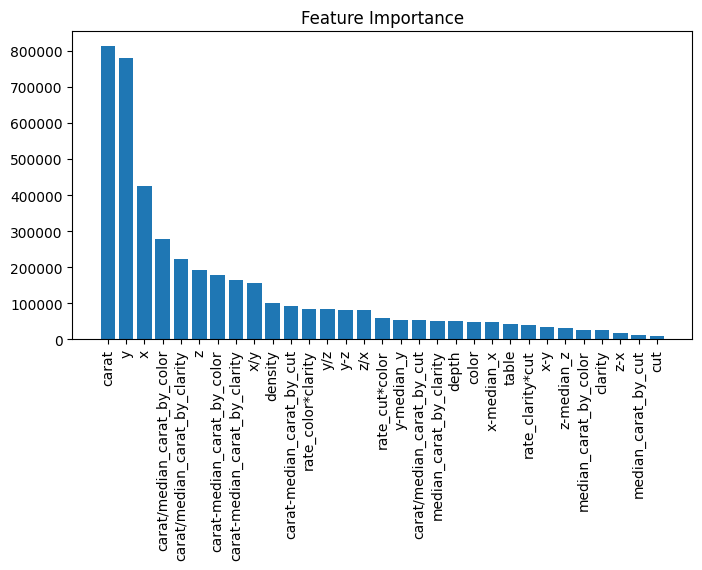

In [ ]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

# クロスバリデーション

In [ ]:
# 最適化ハイパーパラメータを用いたクロスバリデーション
from sklearn.model_selection import KFold

# 格納用データの作成
valid_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    # 最適化ハイパーパラメータを読み込み
    model = lgb.train(params_best,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                      lgb.log_evaluation(500)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MAE valid: {score:.2f}')
    print('')

    # スコア、モデル、予測値の格納
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.164	valid's l1: 246.749
[1000]	train's l1: 177.886	valid's l1: 242.937
[1500]	train's l1: 158.366	valid's l1: 242.278
[2000]	train's l1: 147.191	valid's l1: 241.943
Early stopping, best iteration is:
[1989]	train's l1: 147.405	valid's l1: 241.928
fold 1 MAE valid: 241.93

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.626	valid's l1: 249.24
[1000]	train's l1: 176.42	valid's l1: 246.118
[1500]	train's l1: 156.094	valid's l1: 245.163
[2000]	train's l1: 146.313	valid's l1: 244.693
[2500]	train's l1: 139.223	valid's l1: 244.41
[3000]	train's l1: 133.348	valid's l1: 244.237
Early stopping, best iteration is:
[3034]	train's l1: 132.964	valid's l1: 244.22
fold 2 MAE valid: 244.22

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.699	valid's l1: 251.944
[1000]	train's l1: 179.891	valid's l1: 247.809
[1500]	train's l1: 159.422	valid's l1: 24

In [ ]:
# 検証データの誤差
valid_scores

[241.92787340734705,
 244.2196698204141,
 245.78150048457576,
 245.59781386253843,
 245.78883698359985]

In [ ]:
# 検証データの誤差平均
cv_score

244.66313891169503

In [ ]:
# 検証データの誤差平均
print('MAE CV: %.2f' % (
      mean_absolute_error(y_train, oof)))

MAE CV: 244.66
